#### Práctica 2: Tipología y ciclo de vida de los datos
# Análisis sobre enfermedades cardiacas
#### Autores: 
- Víctor H. Ayala Sánchez  
- Clara M. Roca de la Concha

https://archive.ics.uci.edu/ml/datasets/heart+disease

# Tabla de contenidos

- 1. [Descripción del dataset](#1.-Descripción-del-dataset)
- 2. [Integración y selección de los datos de interés a analizar](#2.-Integración-y-selección-de-los-datos-de-interés-a-analizar)
- 3. [Limpieza de los datos](#3.-Limpieza-de-los-datos)
    - 3.1. [¿Los datos contienen ceros o elementos vacíos?](#3.1.-¿Los-datos-contienen-ceros-o-elementos-vacíos?)
    - 3.2. [Identifica y gestiona los valores extremos](#3.2.-Identifica-y-gestiona-los-valores-extremos)
- 4.[Análisis de los datos](#4.-Análisis-de-los-datos)
    - 4.1.[Selección de los grupos de datos que se quieren analizar/comparar](#4.1.-Selección-de-los-grupos-de-datos-que-se-quieren-analizar/comparar)
    - 4.2.[Comprobación de la normalidad y homogeneidad de la varianza](#4.2.-Comprobación-de-la-normalidad-y-homogeneidad-de-la-varianza)
    - 4.3.[Aplicación de pruebas estadísticas para comparar los grupos de datos](#4.3.-Aplicación-de-pruebas-estadísticas-para-comparar-los-grupos-de-datos)
    - 4.4.[Relación entre predictores](#4.4.-Relación-entre-predictores)
    - 4.5 [Modelaje Estadístico](#4.4.-Modelaje-Estadístico)
- 5.[Representación gráfica](#5.-Representación-gráfica)
- 6.[Resolución del problema](#6.-Resolución-del-problema)
- 7.[Código](#7.-Código)
- 8.[Vídeo](#8.-Vídeo)
- [Contribuciones](#Contribuciones)

# Librerías

In [143]:
import pandas as pd
import numpy as np
from scipy.stats import levene
from scipy.stats import fligner
from scipy import stats


import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from joblib import dump, load

# 1. Descripción del dataset

**¿Por qué es importante y qué pregunta/problema pretende responder?**			

Partimos del dataset recomendado por la asignatura: [*Heart Attack Analysis & Prediction dataset*](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset). En principio, este dataset trata de explicar la enfermedad cardiaca a partir de una serie de factores, como el colesterol o la frecuencia cardiaca. No obstante, aclararemos que este dataset es útil para practicar, pero no tanto para resolver un problema real, tal como ya se comenta [en el foro del propio dataset en Kaggle](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset/discussion/249239). 

En un análisis preliminar de los datos, podemos comprobar que el archivo `heart.csv` consta de 303 registros y 14 variables. La información de Kaggle es escasa, puesto que no proporciona información espacio-temporal sobre los datos. Tampoco proporciona citas adicionales sobre las fuentes, siendo que es improbable que los que proporcionan este dataset sean los autores de la investigación. Nótese que señalan la procedencia 'online' y el método 'crawling'. 

Una búsqueda rápida nos llevará a encontrar [el origen de los datos](https://archive.ics.uci.edu/ml/datasets/heart+disease). Se trata de un popular dataset donado en 1988. El estudio original consta de 4 ubicaciones:
1. Budapest (Hungría): Hungarian Institute of Cardiology, Andras Janosi, M.D.
2. Zurich (Suiza): University Hospital, William Steinbrunn, M.D.
3. Basilea (Suiza): University Hospital, Matthias Pfisterer, M.D.
4. Cleveland (Estados Unidos): V.A. Medical Center, Long Beach and Cleveland Clinic Foundation, Robert Detrano, M.D., Ph.D.

Originalmente, constaba de 76 atributos, si bien "todos los experimentos publicados se refieren a 14 atributos", tal como se nos indica [en el repositorio original](https://archive.ics.uci.edu/ml/datasets/heart+disease). Los datos compartidos en Kaggle proceden del dataset de Cleveland, el más popular en los estudios de Machine Learning. 

Por lo tanto, tenemos en nuestras manos un dataset cuya fuente original no está citada, con un número de registros menor al ideal en un estudio de estas características y de una antigüedad considerable. Presenta además algunas dificultades, como el hecho de que algunos valores no se corresponden con los establecidos en la descripción de los datos. Por ejemplo, la variable `cp` ('chest pain type') va del 0 al 3 mientras que en la descripción –tanto en kaggle como en el repositorio de UCI– va del 1 al 4. Instuitivamente cabe pensar que el 1 original pasó al 0 y el 4, al 3. Sin embargo, comparando los datos de Kaggle con el dataset original, podemos comprobar que esto no es así. Otros valores hacen saltar las alarmas, como la asignación en la variable `output`. Por este motivo, hemos tomado la decisión de partir directamente del dataset original, que se encuentra [aquí](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/) bajo el nombre `processed.cleveland.data`.

Dicho esto, pasamos a describir las variables que tenemos entre manos:

`age`: edad del paciente 

`sex`: sexo del paciente

        0 = mujer
        1 = hombre
`cp`: tipo de dolor de pecho. 

        1 = angina típica
        2 = angina atípica
        3 = dolor no anginoso
        4 = asintomático
        
`trestbps` : presión sanguínea en reposo (en mm Hg)

`chol` : colesterol en mg/dl

`fbs` : azúcar en sangre en ayunas > 120 mg/dl.

        0 = falso
        1 = verdadero
        
`restecg` : resultados electrocardiográficos en reposo

        0 = normal
        1 = anomalías en la onda ST-T
        2 = hipertrofia ventricular izquierda
        
`thalach` : frecuencia cardiaca máxima alcanzada.

`exang`: angina inducida por el ejercicio

        0 = no
        1 = sí
        
`oldpeak`: depresión del ST inducida por el ejercicio en relación con el reposo

`slope`: la pendiente del segmento ST de ejercicio máximo.

        1 = pendiente ascendiente 
        2 = sin pendiente
        3 = pendiente descendente
        
`ca`: número de vasos principales (de 0 a 3)

`thal`: Thallium Stress Test, por lo que podemos leer [aquí](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset/discussion/234843?sort=votes)

        3 = normal
        6 = defecto arreglado
        7 = defecto reversible 

`num`: atributo predicho; diagnóstico de enfermedad cardíaca (estado de enfermedad angiográfico)

        0 = ausencia de enfermedad cardíaca
        1, 2, 3 o 4 = presencia de enfermedad cardíaca

# 2. Integración y selección de los datos de interés a analizar
**Puede ser el resultado de adicionar diferentes datasets o una subselección útil de los datos originales, en base al objetivo que se quiera conseguir.**

Usaremos el dataset al completo, teniendo en cuenta que ya se parte de una reducción del original, que contenía 76 variables, si bien sí realizaremos ciertas modificaciones que pasamos a describir aquí:

1. Añadimos el nombre de las columnas, no presente en el archivo.
2. Convertimos los valores de ciertas variables para unificar las categorías de 'normal' o 'asintomático' en 0:
    a. `cp`:
        
        0 = asintomático (antes 4)
        1 = angina típica
        2 = angina atípica
        3 = dolor no anginoso
        
    b. `thal`:
    
        0 = normal (antes 3)
        1 = defecto arreglado (antes 6)
        2 = defecto reversible (antes 7)

3. Unificamos todos los resultados en `num` de presencia de enfermedad cardíaca en 1 para que quede:
    
        0 = ausencia de enfermedad cardíaca
        1 = presencia de enfermedad cardíaca
        
Antes de realizar todos estos cambios, deberemos asegurarnos de que no haya algún valor nulo imputado con estos números.   

In [2]:
# Añadimos al dataset el nombre correspondiente de cada columna
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 
           'fbs', 'restecg', 'thalach', 'exang', 
           'oldpeak', 'slope', 'ca', 'thal', 'num']
df = pd.read_csv("data/processed.cleveland.csv", header=None, names=columns)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  num       303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


Vamos a homogeneizar el dataframe y pasar todo a numeric. Usaremos `errors='coerce'` para convertir en nulos los valores no numéricos.

In [4]:
df = df.apply(pd.to_numeric, errors='coerce')

A continuación, podemos comprobar que, efectivamente, `ca`contiene 4 valores nulos y `thal`, 2.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


Visto que, efectivamente, todas las variables se ajustan a lo indicado en la descripción del dataset, procedemos a recodificar las variables indicadas.

In [6]:
df = df.replace({
    'cp': {
        4: 0
        },
   
    'thal':{ 
        3 : "normal",
        6.0 : "fixed defect",
        7.0 : "reversable defect"
        #'?': np.NaN
    },
    
    'num':{ 
        2 : 1,
        3 : 1,
        4 : 1
    }  
    
})
        
df.sample(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
221,54.0,0.0,3.0,108.0,267.0,0.0,2.0,167.0,0.0,0.0,1.0,0.0,normal,0
275,64.0,1.0,1.0,170.0,227.0,0.0,2.0,155.0,0.0,0.6,2.0,0.0,reversable defect,0
89,51.0,0.0,3.0,130.0,256.0,0.0,2.0,149.0,0.0,0.5,1.0,0.0,normal,0
174,64.0,1.0,0.0,145.0,212.0,0.0,2.0,132.0,0.0,2.0,2.0,2.0,fixed defect,1
167,54.0,0.0,2.0,132.0,288.0,1.0,2.0,159.0,1.0,0.0,1.0,1.0,normal,0


# 3. Limpieza de los datos

## 3.1. ¿Los datos contienen ceros o elementos vacíos? 
**Gestiona cada uno de estos casos.**

Como ya hemos podido comprobar, existen valores nulos en la variable `ca`y en la variable `thal`.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    object 
 13  num       303 non-null    int64  
dtypes: float64(12), int64(1), object(1)
memory usage: 33.3+ KB


Realizamos un preprocesamiento, haciendo replace sobre las variables categóricas para poder analizar los datos

In [8]:
df = df.replace({
    'cp': {
        0: 'typical angina',
        1: 'atypical angina',
        2: 'non-anginal pain',
        3: 'asymptomatic'
        },
    'sex':{
        1:'Male',
        0:'Female'
    },
    'restecg':{
        0:'Normal',
        1:'ST-T wave abnormality',
        2:'Left ventricular hypertrophy'
    },
    'exang':{
        0:'Yes Angina',
        1:'No Angina'
    },
    'fbs':{
        0:'fastingBloodSugar_false',
        1:'fastingBloodSugar_true'  
    },
    'slope':{
        1:'upsloping',
        2:'flat',
        3:'downsloping'
    },

})

df.sample(4)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
26,58.0,Female,asymptomatic,120.0,340.0,fastingBloodSugar_false,Normal,172.0,Yes Angina,0.0,upsloping,0.0,normal,0
116,58.0,Male,asymptomatic,140.0,211.0,fastingBloodSugar_true,Left ventricular hypertrophy,165.0,Yes Angina,0.0,upsloping,0.0,normal,0
219,59.0,Male,typical angina,138.0,271.0,fastingBloodSugar_false,Left ventricular hypertrophy,182.0,Yes Angina,0.0,upsloping,0.0,normal,0
256,67.0,Female,typical angina,106.0,223.0,fastingBloodSugar_false,Normal,142.0,Yes Angina,0.3,upsloping,2.0,normal,0


Una vez realizado el proceso de replace podemos notar que tenemos dos registros con valores aunsentes o perdidos en la variable **thal** y **ca**

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    object 
 2   cp        303 non-null    object 
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    object 
 6   restecg   303 non-null    object 
 7   thalach   303 non-null    float64
 8   exang     303 non-null    object 
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    object 
 11  ca        299 non-null    float64
 12  thal      301 non-null    object 
 13  num       303 non-null    int64  
dtypes: float64(6), int64(1), object(7)
memory usage: 33.3+ KB


Considerando que son solo 6 registros y que representan menos del 5% de los datos decidimos directamente eliminarlos del conjunto de datos. 

In [10]:
df.dropna(inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    float64
 1   sex       297 non-null    object 
 2   cp        297 non-null    object 
 3   trestbps  297 non-null    float64
 4   chol      297 non-null    float64
 5   fbs       297 non-null    object 
 6   restecg   297 non-null    object 
 7   thalach   297 non-null    float64
 8   exang     297 non-null    object 
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    object 
 11  ca        297 non-null    float64
 12  thal      297 non-null    object 
 13  num       297 non-null    int64  
dtypes: float64(6), int64(1), object(7)
memory usage: 34.8+ KB


## 3.2. Identifica y gestiona los valores extremos



Mediante el análisis gráfico de las distribuciones observamos algunos valores extremos en las variables **trestbps**, **chol**, **thalach** y **oldpeak**

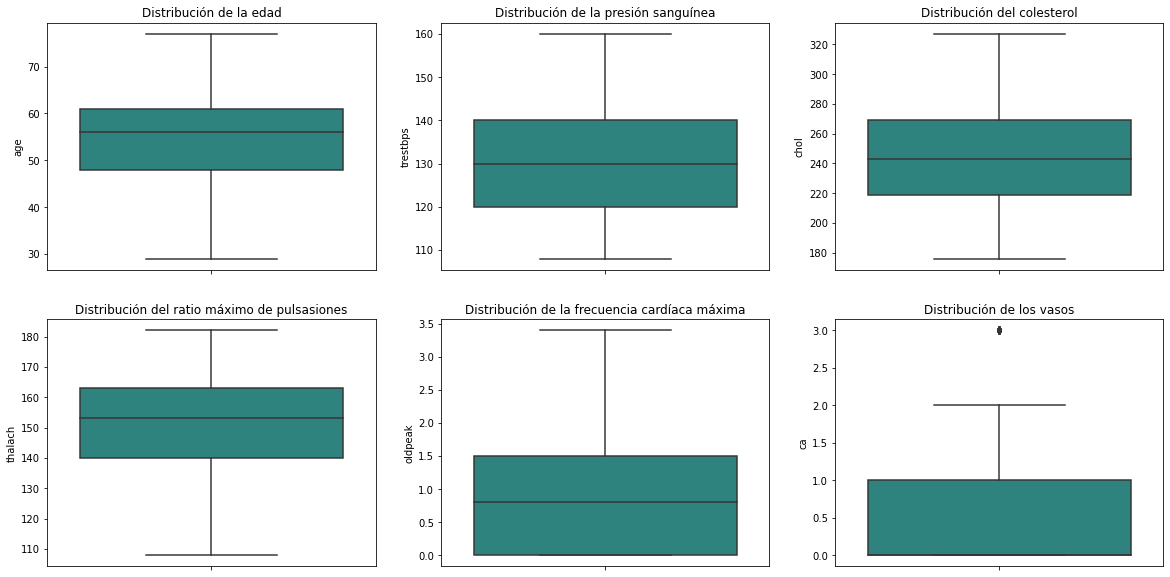

In [112]:
fig, axes = plt.subplots(2, 3, figsize=(20,10))

sns.boxplot(ax=axes[0,0], y="age", palette="viridis", data=df).set(title='Distribución de la edad')
sns.boxplot(ax=axes[0,1], y="trestbps", palette="viridis", data=df).set(title='Distribución de la presión sanguínea')
sns.boxplot(ax=axes[0,2], y="chol" ,palette="viridis", data=df).set(title='Distribución del colesterol')

sns.boxplot(ax=axes[1,0], y="thalach" ,palette="viridis", data=df).set(title='Distribución del ratio máximo de pulsasiones')
sns.boxplot(ax=axes[1,1], y="oldpeak" ,palette="viridis", data=df).set(title='Distribución de la frecuencia cardíaca máxima')
sns.boxplot(ax=axes[1,2], y="ca" ,palette="viridis", data=df).set(title='Distribución de los vasos')

plt.show()

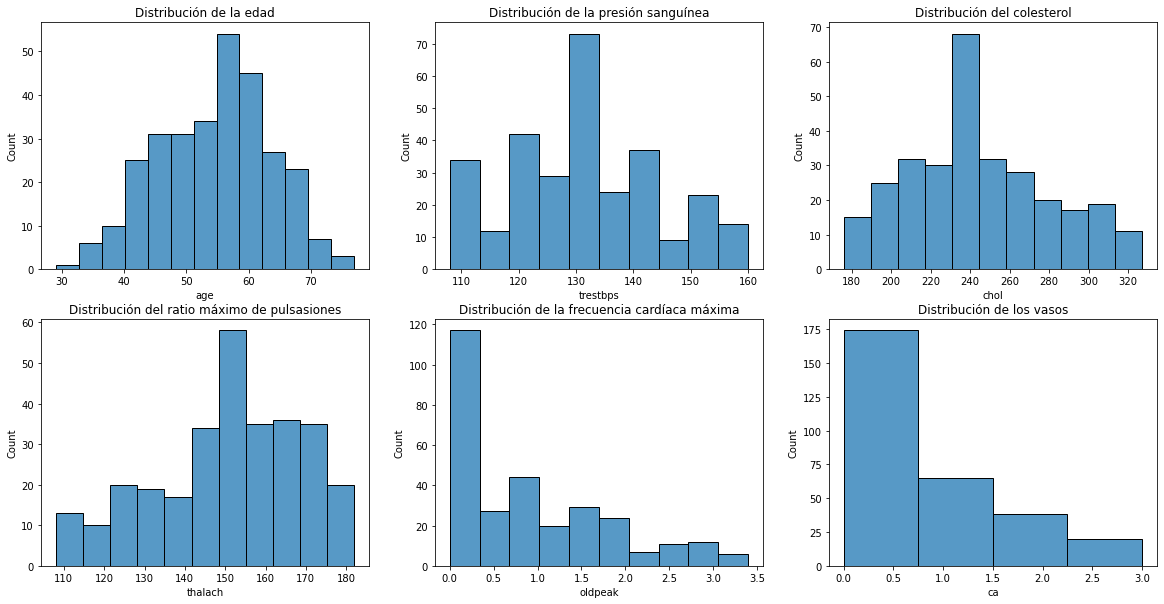

In [109]:
fig, axes = plt.subplots(2, 3, figsize=(20,10))

sns.histplot(ax=axes[0,0], x="age", palette="viridis", data=df).set(title='Distribución de la edad')
sns.histplot(ax=axes[0,1], x="trestbps", palette="viridis", data=df).set(title='Distribución de la presión sanguínea')
sns.histplot(ax=axes[0,2], x="chol" ,palette="viridis", data=df).set(title='Distribución del colesterol')

sns.histplot(ax=axes[1,0], x="thalach" ,palette="viridis", data=df).set(title='Distribución del ratio máximo de pulsasiones')
sns.histplot(ax=axes[1,1], x="oldpeak" ,palette="viridis", data=df).set(title='Distribución de la frecuencia cardíaca máxima')
sns.histplot(ax=axes[1,2], x="ca" ,palette="viridis", data=df, bins=4).set(title='Distribución de los vasos')

plt.show()

In [14]:
df.describe()

,age,trestbps,chol,thalach,oldpeak,ca,num
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,131.693603,247.350168,149.599327,1.055556,0.676768,0.461279
std,9.049736,17.762806,51.997583,22.941562,1.166123,0.938965,0.499340
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000,0.000000
25%,48.000000,120.000000,211.000000,133.000000,0.000000,0.000000,0.000000
50%,56.000000,130.000000,243.000000,153.000000,0.800000,0.000000,0.000000
75%,61.000000,140.000000,276.000000,166.000000,1.600000,1.000000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,3.000000,1.000000


Además de los gráficos de boxplot, observando la tabla de estadísticos descriptivos podemos detectar valores máximos que se encuentran varias desviaciones por encima de la media, este caso se da en las distribuciones como en trtbps, chol, thalachh etc.


Definimos la siguiente función para reemplazar aquellos valores que se encuentren por encima del percentil 95 o por debajo del percentil 5, considerados como valores extremos, dicho reemplazo se realizará por el percentil 85 y 10 respectivamente.

In [15]:
def replaceOuliers(column):
    """
    """
    colReplace = np.array(column)
    median = np.median(column)
    
    upper =  np.percentile(np.array(column),95)
    lower =  np.percentile(np.array(column),5)
    
    #colReplace[colReplace[:] > upper] = np.percentile(np.array(column),85)
    #colReplace[colReplace[:] < lower] = np.percentile(np.array(column),10)
    
    colReplace[colReplace[:] > upper] = median
    colReplace[colReplace[:] < lower] = median
    
    return list(colReplace)

In [16]:
df["trestbps"] = replaceOuliers(list(df["trestbps"]))
df["chol"] = replaceOuliers(list(df["chol"]))
df["thalach"] = replaceOuliers(list(df["thalach"]))
df["oldpeak"] = replaceOuliers(list(df["oldpeak"]))


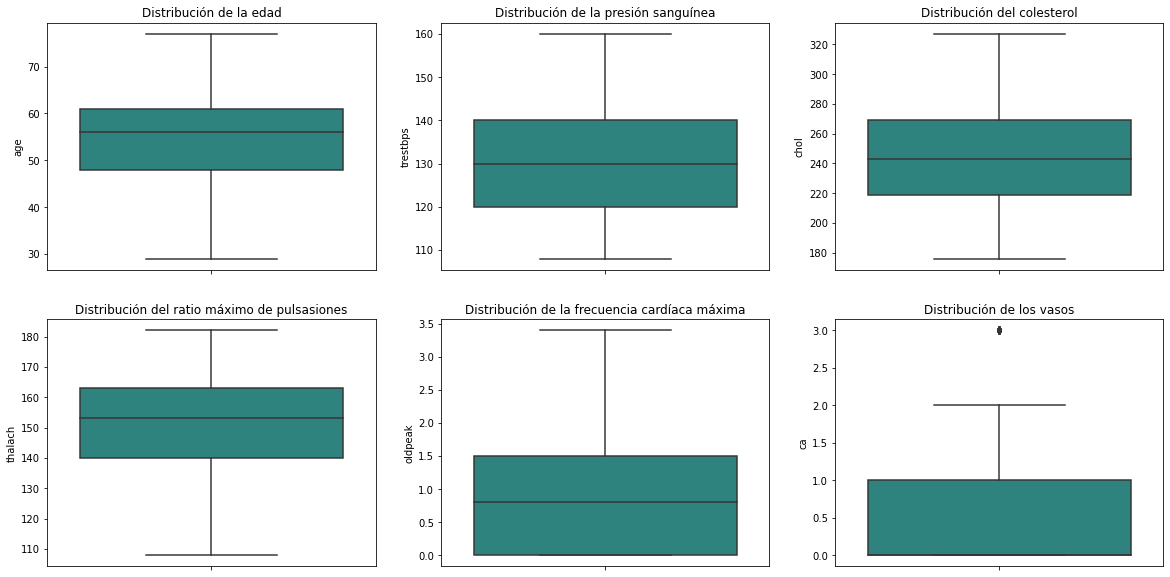

In [89]:
fig, axes = plt.subplots(2, 3, figsize=(20,10))

sns.boxplot(ax=axes[0,0], y="age", palette="viridis", data=df).set(title='Distribución de la edad')
sns.boxplot(ax=axes[0,1], y="trestbps", palette="viridis", data=df).set(title='Distribución de la presión sanguínea')
sns.boxplot(ax=axes[0,2], y="chol" ,palette="viridis", data=df).set(title='Distribución del colesterol')

sns.boxplot(ax=axes[1,0], y="thalach" ,palette="viridis", data=df).set(title='Distribución del ratio máximo de pulsasiones')
sns.boxplot(ax=axes[1,1], y="oldpeak" ,palette="viridis", data=df).set(title='Distribución de la frecuencia cardíaca máxima')
sns.boxplot(ax=axes[1,2], y="ca" ,palette="viridis", data=df).set(title='Distribución de los vasos')

plt.show()

# 4. Análisis de los datos

### Análisis Exploratorio de datos

In [18]:
df[["age","trestbps","chol","thalach","oldpeak","ca"]].describe()

,age,trestbps,chol,thalach,oldpeak,ca
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,130.713805,245.030303,150.868687,0.896970,0.676768
std,9.049736,12.870545,35.974781,18.162357,0.923542,0.938965
min,29.000000,108.000000,176.000000,108.000000,0.000000,0.000000
25%,48.000000,120.000000,219.000000,140.000000,0.000000,0.000000
50%,56.000000,130.000000,243.000000,153.000000,0.800000,0.000000
75%,61.000000,140.000000,269.000000,163.000000,1.500000,1.000000
max,77.000000,160.000000,327.000000,182.000000,3.400000,3.000000


A continuación se presentan las distribuciones de las variables en función del target o variable a predecir

### Age

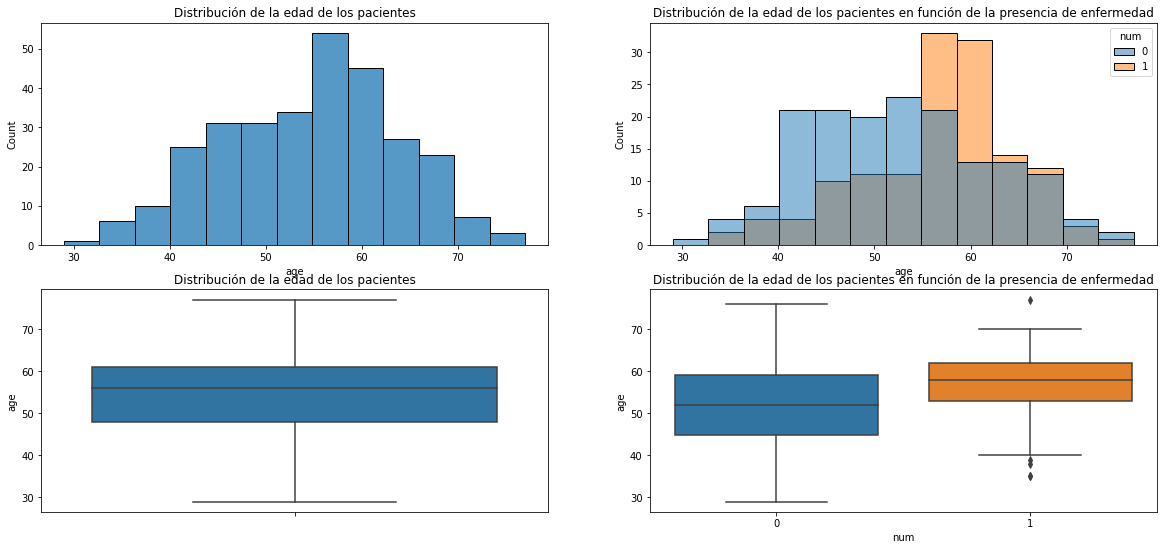

In [93]:
fig, axes = plt.subplots(2, 2, figsize=(20,9))

sns.histplot(x=df["age"], ax=axes[0,0]).set(title='Distribución de la edad de los pacientes')
sns.histplot(x=df["age"], hue=df["num"], ax=axes[0,1]).set(title='Distribución de la edad de los pacientes en función de la presencia de enfermedad')

sns.boxplot(y=df["age"], ax=axes[1,0]).set(title='Distribución de la edad de los pacientes')
sns.boxplot(y=df["age"], x=df["num"], ax=axes[1,1]).set(title='Distribución de la edad de los pacientes en función de la presencia de enfermedad')

plt.show()

In [20]:
df[["age","num"]].groupby("num").describe().T

num                 0           1
age count  160.000000  137.000000
    mean    52.643750   56.759124
    std      9.551151    7.899670
    min     29.000000   35.000000
    25%     44.750000   53.000000
    50%     52.000000   58.000000
    75%     59.000000   62.000000
    max     76.000000   77.000000

Se puede observar comparando las distribuciones, que la mediana y el promedio de la edad de las personas que enferman es mayor que las personas sanas. 

### Sex

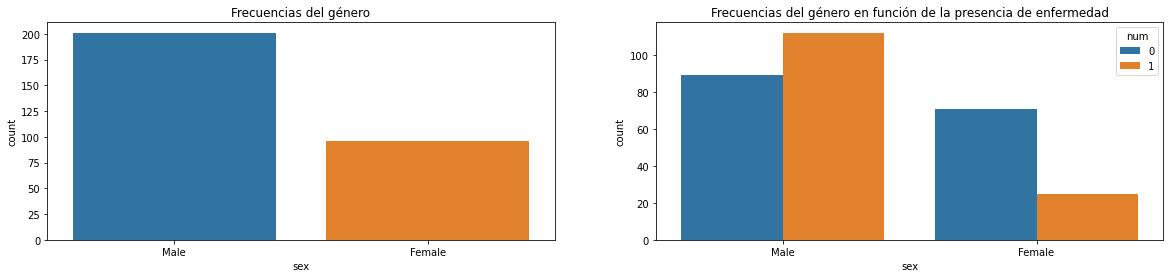

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(20,4))

sns.countplot(x=df["sex"], ax=axes[0]).set(title='Frecuencias del género')

sns.countplot(x=df["sex"], hue=df["num"], ax=axes[1]).set(title='Frecuencias del género en función de la presencia de enfermedad')

plt.show()

In [22]:
pd.crosstab(index= df["sex"], columns=df["num"], normalize=True)

num,0,1
sex,,
Female,0.239057,0.084175
Male,0.299663,0.377104


Se observa que la proporción de mujeres que enferman es baja dentro de la muestra estudiada

### CP

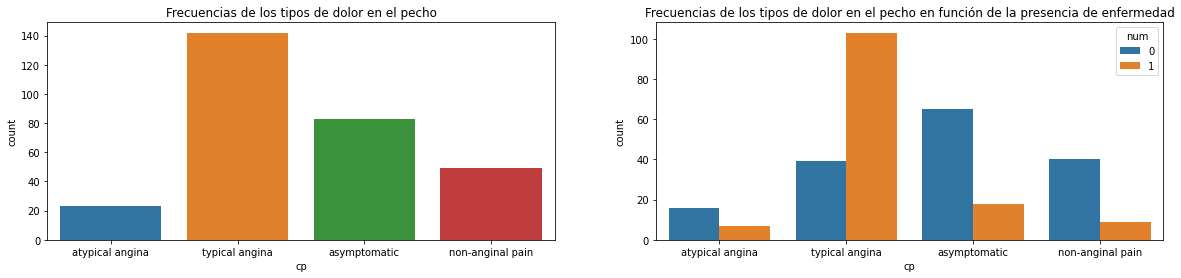

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(20,4))

sns.countplot(x=df["cp"], ax=axes[0]).set(title='Frecuencias de los tipos de dolor en el pecho')

sns.countplot(x=df["cp"], hue=df["num"], ax=axes[1]).set(title='Frecuencias de los tipos de dolor en el pecho en función de la presencia de enfermedad')

plt.show()

In [24]:
pd.crosstab(index= df["cp"], columns=df["num"], normalize=True)

num,0,1
cp,,
asymptomatic,0.218855,0.060606
atypical angina,0.053872,0.023569
non-anginal pain,0.134680,0.030303
typical angina,0.131313,0.346801


La angina típica para ser el tipo de dolor más asociado a la presencia de la enfermedad

### trestbps

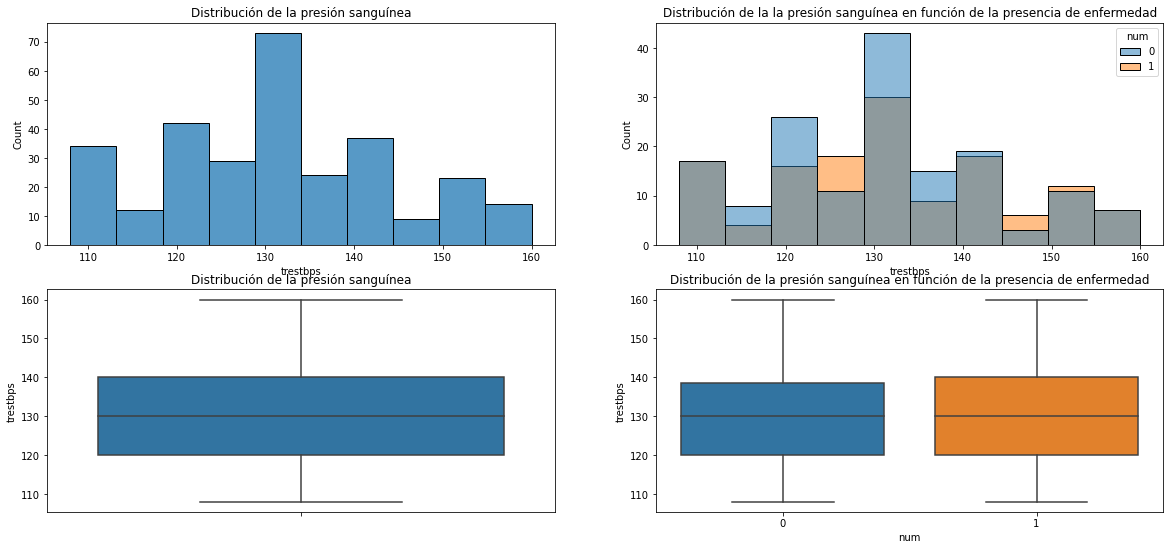

In [96]:
fig, axes = plt.subplots(2, 2, figsize=(20,9))

sns.histplot(x=df["trestbps"], ax=axes[0,0]).set(title='Distribución de la presión sanguínea')
sns.histplot(x=df["trestbps"], hue=df["num"], ax=axes[0,1]).set(title='Distribución de la la presión sanguínea en función de la presencia de enfermedad')

sns.boxplot(y=df["trestbps"], ax=axes[1,0]).set(title='Distribución de la presión sanguínea')
sns.boxplot(y=df["trestbps"], x=df["num"], ax=axes[1,1]).set(title='Distribución de la presión sanguínea en función de la presencia de enfermedad')

plt.show()

In [26]:
df[["trestbps","num"]].groupby("num").describe().T

num                      0           1
trestbps count  160.000000  137.000000
         mean   130.187500  131.328467
         std     12.447721   13.367052
         min    108.000000  108.000000
         25%    120.000000  120.000000
         50%    130.000000  130.000000
         75%    138.500000  140.000000
         max    160.000000  160.000000

Parece no haber grandes diferencias en los estadísticos de tendencia central en las distribuciones de las presión sanguínea entre personas enfermas y sanas

### Chol

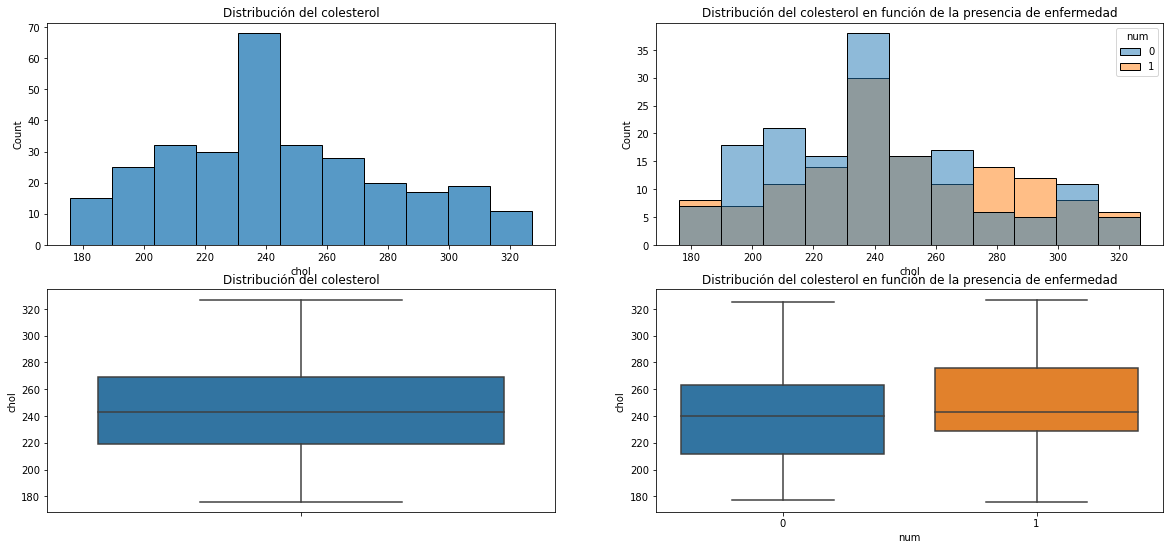

In [97]:
fig, axes = plt.subplots(2, 2, figsize=(20,9))

sns.histplot(x=df["chol"], ax=axes[0,0]).set(title='Distribución del colesterol')
sns.histplot(x=df["chol"], hue=df["num"], ax=axes[0,1]).set(title='Distribución del colesterol en función de la presencia de enfermedad')

sns.boxplot(y=df["chol"], ax=axes[1,0]).set(title='Distribución del colesterol')
sns.boxplot(y=df["chol"], x=df["num"], ax=axes[1,1]).set(title='Distribución del colesterol en función de la presencia de enfermedad')

plt.show()

In [28]:
df[["chol","num"]].groupby("num").describe().T

num                  0           1
chol count  160.000000  137.000000
     mean   240.712500  250.072993
     std     35.456659   36.047484
     min    177.000000  176.000000
     25%    211.750000  229.000000
     50%    240.000000  243.000000
     75%    263.000000  276.000000
     max    325.000000  327.000000

El nivel de colesterol, en promedio, es más elevado en las personas que presentan la enfermedad

### fbs

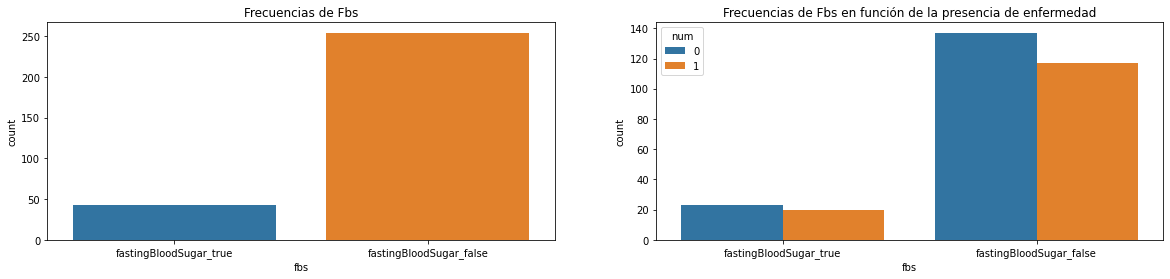

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(20,4))

sns.countplot(x=df["fbs"], ax=axes[0]).set(title='Frecuencias de Fbs')

sns.countplot(x=df["fbs"], hue=df["num"], ax=axes[1]).set(title='Frecuencias de Fbs en función de la presencia de enfermedad')

plt.show()

In [30]:
pd.crosstab(index= df["fbs"], columns=df["num"], normalize=True)

num,0,1
fbs,,
fastingBloodSugar_false,0.461279,0.393939
fastingBloodSugar_true,0.077441,0.067340


### restecg

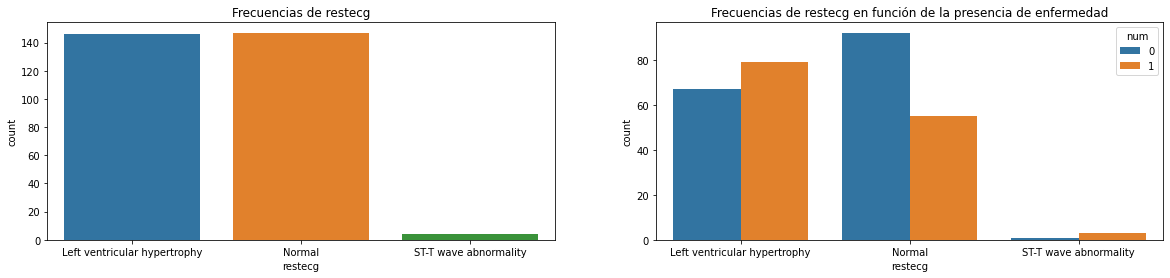

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(20,4))

sns.countplot(x=df["restecg"], ax=axes[0]).set(title='Frecuencias de restecg')

sns.countplot(x=df["restecg"], hue=df["num"], ax=axes[1]).set(title='Frecuencias de restecg en función de la presencia de enfermedad')

plt.show()

In [32]:
pd.crosstab(index= df["restecg"], columns=df["num"], normalize=True)

num,0,1
restecg,,
Left ventricular hypertrophy,0.225589,0.265993
Normal,0.309764,0.185185
ST-T wave abnormality,0.003367,0.010101


La presencia de enfermedad se asocia en mayor proporción en los casos con hipertrofia ventricular izquierda

### thalach

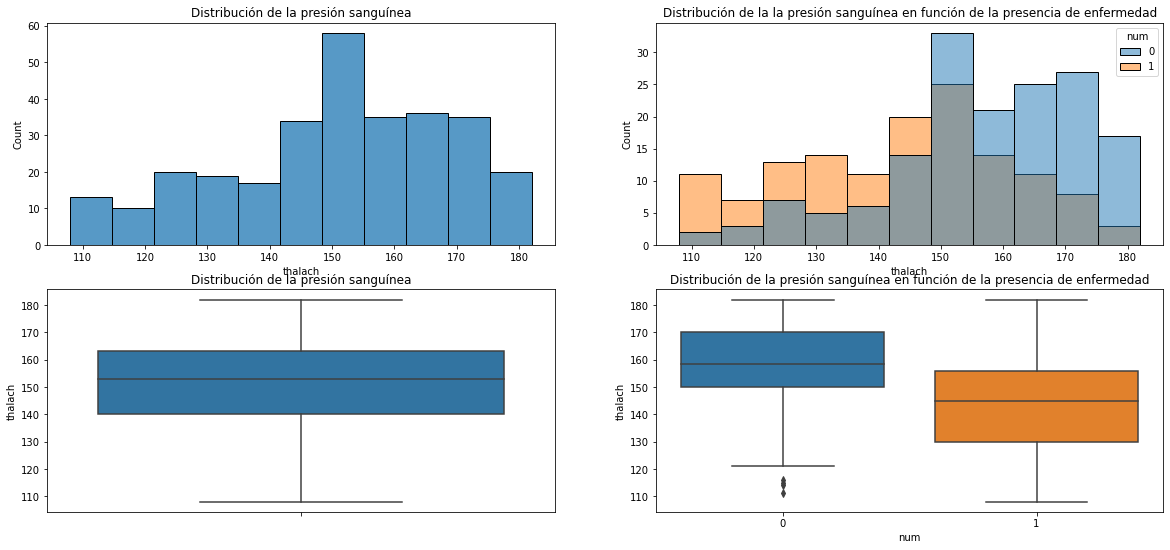

In [100]:
fig, axes = plt.subplots(2, 2, figsize=(20,9))

sns.histplot(x=df["thalach"], ax=axes[0,0]).set(title='Distribución de la presión sanguínea')
sns.histplot(x=df["thalach"], hue=df["num"], ax=axes[0,1]).set(title='Distribución de la la presión sanguínea en función de la presencia de enfermedad')

sns.boxplot(y=df["thalach"], ax=axes[1,0]).set(title='Distribución de la presión sanguínea')
sns.boxplot(y=df["thalach"], x=df["num"], ax=axes[1,1]).set(title='Distribución de la presión sanguínea en función de la presencia de enfermedad')

plt.show()

### Exang

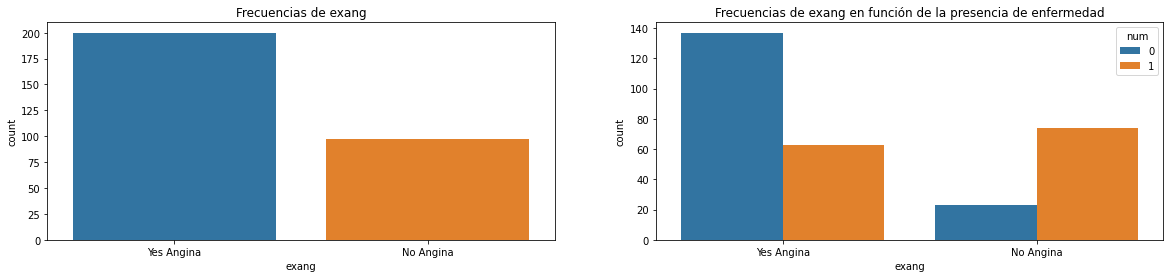

In [101]:
fig, axes = plt.subplots(1, 2, figsize=(20,4))

sns.countplot(x=df["exang"], ax=axes[0]).set(title='Frecuencias de exang')

sns.countplot(x=df["exang"], hue=df["num"], ax=axes[1]).set(title='Frecuencias de exang en función de la presencia de enfermedad')

plt.show()

In [35]:
pd.crosstab(index= df["exang"], columns=df["num"], normalize=True)

num,0,1
exang,,
No Angina,0.077441,0.249158
Yes Angina,0.461279,0.212121


La ausencia de angina tiene una mayor proporción de casos en los que está presente la enfermedad

### Oldpeak

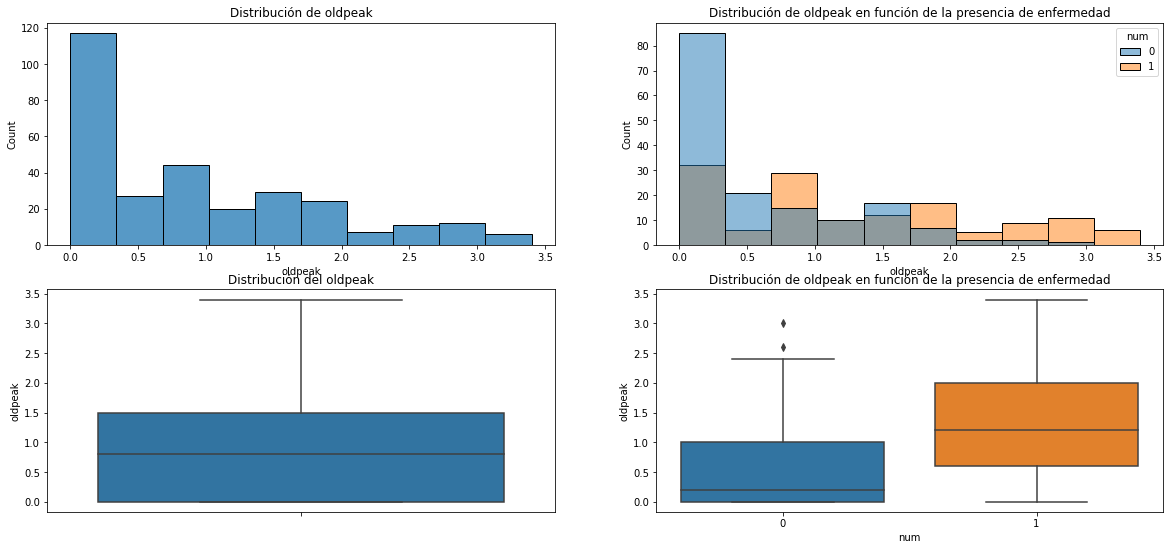

In [102]:
fig, axes = plt.subplots(2, 2, figsize=(20,9))

sns.histplot(x=df["oldpeak"], ax=axes[0,0]).set(title='Distribución de oldpeak')
sns.histplot(x=df["oldpeak"], hue=df["num"], ax=axes[0,1]).set(title='Distribución de oldpeak en función de la presencia de enfermedad')

sns.boxplot(y=df["oldpeak"], ax=axes[1,0]).set(title='Distribución del oldpeak')
sns.boxplot(y=df["oldpeak"], x=df["num"], ax=axes[1,1]).set(title='Distribución de oldpeak en función de la presencia de enfermedad')

plt.show()

In [37]:
df[["oldpeak","num"]].groupby("num").describe().T

num                     0           1
oldpeak count  160.000000  137.000000
        mean     0.560625    1.289781
        std      0.695818    1.000903
        min      0.000000    0.000000
        25%      0.000000    0.600000
        50%      0.200000    1.200000
        75%      1.000000    2.000000
        max      3.000000    3.400000

La presencia de enfermedad se asocia a mayores valores en oldpeak

### Slope

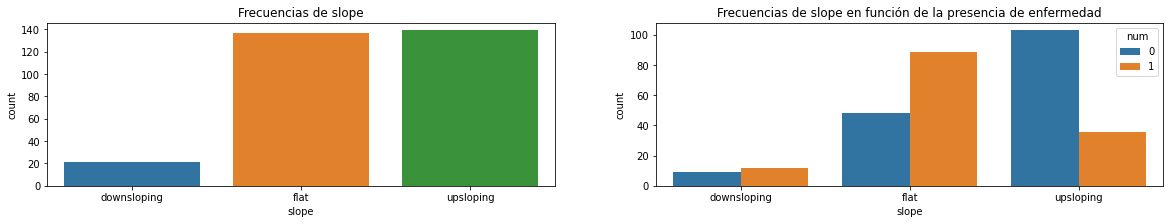

In [105]:
fig, axes = plt.subplots(1, 2, figsize=(20,3))

sns.countplot(x=df["slope"], ax=axes[0]).set(title='Frecuencias de slope')

sns.countplot(x=df["slope"], hue=df["num"], ax=axes[1]).set(title='Frecuencias de slope en función de la presencia de enfermedad')

plt.show()

In [39]:
pd.crosstab(index= df["slope"], columns=df["num"], normalize=True)

num,0,1
slope,,
downsloping,0.030303,0.040404
flat,0.161616,0.299663
upsloping,0.346801,0.121212


La proporción de mayor se da en pacientes con el slope flat y se asoacia a la ausencia de enfermedad

### Ca

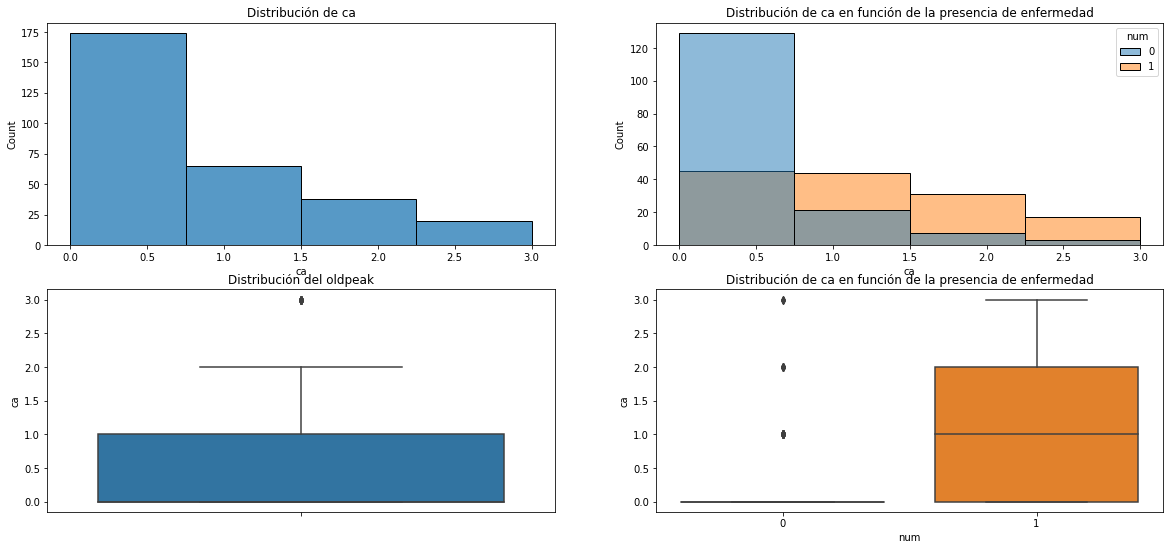

In [106]:
fig, axes = plt.subplots(2, 2, figsize=(20,9))

sns.histplot(x=df["ca"], ax=axes[0,0], bins=4).set(title='Distribución de ca')
sns.histplot(x=df["ca"], hue=df["num"], ax=axes[0,1], bins=4).set(title='Distribución de ca en función de la presencia de enfermedad')

sns.boxplot(y=df["ca"], ax=axes[1,0]).set(title='Distribución del oldpeak')
sns.boxplot(y=df["ca"], x=df["num"], ax=axes[1,1]).set(title='Distribución de ca en función de la presencia de enfermedad')

plt.show()

In [41]:
df[["ca","num"]].groupby("num").describe().T

num                0           1
ca count  160.000000  137.000000
   mean     0.275000    1.145985
   std      0.633945    1.018506
   min      0.000000    0.000000
   25%      0.000000    0.000000
   50%      0.000000    1.000000
   75%      0.000000    2.000000
   max      3.000000    3.000000

La presencia de vasos se asocia a la presencia de la enfermedad

### Thal

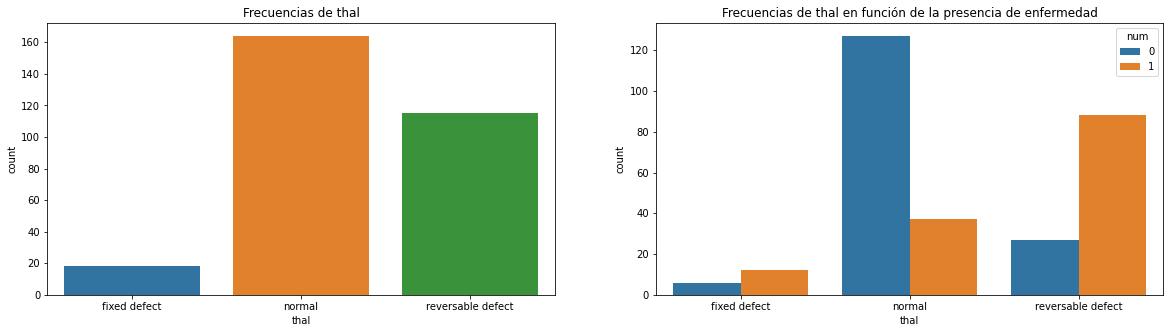

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x=df["thal"], ax=axes[0]).set(title='Frecuencias de thal')
sns.countplot(x=df["thal"], hue=df["num"], ax=axes[1]).set(title='Frecuencias de thal en función de la presencia de enfermedad')
plt.show()

In [43]:
pd.crosstab(index= df["thal"], columns=df["num"], normalize=True)

num,0,1
thal,,
fixed defect,0.020202,0.040404
normal,0.427609,0.124579
reversable defect,0.090909,0.296296


Por lo general los pacientes con **thal=normal** tienden a estar sanos.

## 4.1. Selección de los grupos de datos que se quieren analizar/comparar 
**(p.ej., si se van a comparar grupos de datos, ¿cuáles son estos grupos y
qué tipo de análisis se van a aplicar?)**

A lo largo de la presente investigación se van a comparar los grupos de pacientes enfermos y pacientes sanos

## 4.2. Comprobación de la normalidad y homogeneidad de la varianza

Para comprobar la normalidad de las variables cuantitiativas utilizaremos el famoso test de Shapiro-Wilk. Recordemos que si el *p*-valor resulta ser menor de 0.05 (el nivel de significación), rechazaremos la hipótesis nula, es decir, rechazaremos que los datos tienen una distribución normal. 

Para comprobar la homocedasticidad de los datos (variables cuantitativas), es decir, si existe una igualdad de varianzas entre dos grupos, aplicaremos el test de Levene para aquellas variables que siguen una normal y el test de Fligner-Killeen para las que no lo son. Recordemos que la premisa es la misma que con el test de Shapiro-Wilk: un *p*-valor inferior al nivel de significación $\alpha$ supondrá el rechazo de la hipótesis nula y concluiremos que no existe homogeneidad de varianzas.

Para todos ellos, definimos una función para realizar los contrastes de homogenidad de varianza de forma más efectiva:

In [130]:
# Test de normalidad Shapiro-Wilk
def testNormality(x):
    """
    x: list type to check normality
    
    """
    
    a = np.array(x)
    stat, p = stats.shapiro(x)
    
    if p < 0.05:
        print("Distribution is not normal, p value: {}".format(p))
    else:
        print("Distribution is normal, p value: {}".format(p))

In [44]:
# Test de varianzas Levene en variables con distribución normal
def testLevene(listA, listB):
    """
    listA: list type to compare variance 
    listB: list type to compare variance
    
    """
    
    a = np.array(listA)
    b = np.array(listB)
    stat, p = levene(a, b)
    
    if p < 0.05:
        print("Variances not equal, p value: {}".format(p))
    else:
        print("Variances equal, p value: {}".format(p))

In [144]:
# Test de varianzas Fligner-Killeen en variables con distribución no normal
def testFligner(listA, listB):
    """
    listA: list type to compare variance 
    listB: list type to compare variance
    
    """
    
    a = np.array(listA)
    b = np.array(listB)
    stat, p = fligner(a, b)
    
    if p < 0.05:
        print("Variances not equal, p value: {}".format(p))
    else:
        print("Variances equal, p value: {}".format(p))

Separamos los datos en enfermos y sanos para facilitar los contrastes:

In [158]:
df_sick = df[df["num"] == 1] 
df_healthy = df[df["num"] == 0] 

### `age`

In [145]:
print("\nTest de normalidad para la edad en población con patologías cardiacas:")
testNormality(df_sick["age"])
print("\nTest de normalidad para la edad en población sin patologías cardiacas:")
testNormality(df_healthy["age"])


Test de normalidad para la edad en población con patologías cardiacas:
Distribution is not normal, p value: 0.0016702482243999839

Test de normalidad para la edad en población sin patologías cardiacas:
Distribution is normal, p value: 0.11104635894298553


Siendo rigurosos, visto que una de las distribuciones no sigue una distribución normal, aplicaremos el Test Fligner-Killen para comparar las varianzas. Sin embargo, recordemos que el tamaño de las muestras es superior a 30, por lo tanto, según el Teorema Central del Límite, podríamos asumir que la distribución de la media de la muestra se asemeja a la de una normal.

In [161]:
print(len(df_sick))
print(len(df_healthy))

137
160


In [146]:
print("Test de varianza entre la edad en pacientes con patologías caridacas y sin ellas:")
testFligner(df_sick["age"], df_healthy["age"])

Test de varianza entre la edad en pacientes con patologías caridacas y sin ellas:
Variances not equal, p value: 0.003954117411351063


### `trestbps`

In [149]:
print("\nTest de normalidad para la presión sanguínea en reposo en población con patologías cardiacas:")
testNormality(df_sick["trestbps"])
print("\nTest de normalidad para la presión sanguínea en reposo en población sin patologías cardiacas:")
testNormality(df_healthy["trestbps"])


Test de normalidad para la presión sanguínea en reposo en población con patologías cardiacas:
Distribution is not normal, p value: 0.0011744850780814886

Test de normalidad para la presión sanguínea en reposo en población sin patologías cardiacas:
Distribution is not normal, p value: 0.00020238129945937544


Como ambas distribuciones no son normales, optamos por hacer el test de Fligner-Killeen para la homocedasticidad.

In [162]:
print("Test de varianza entre la presión sanguínea en reposo en pacientes con patologías caridacas y sin ellas:")
testFligner(df_sick["trestbps"], df_healthy["trestbps"])

Test de varianza entre la presión sanguínea en reposo en pacientes con patologías caridacas y sin ellas:
Variances equal, p value: 0.32114310607369934


### `chol`

In [170]:
print("\nTest de normalidad para el colesterol en población con patologías cardiacas:")
testNormality(df_sick["chol"])
print("\nTest de normalidad para el colesterol en población sin patologías cardiacas:")
testNormality(df_healthy["chol"])


Test de normalidad para el colesterol en población con patologías cardiacas:
Distribution is normal, p value: 0.10689220577478409

Test de normalidad para el colesterol en población sin patologías cardiacas:
Distribution is not normal, p value: 0.0006504325428977609


Como una de las distribuciones no es normal, optamos por hacer el test de Fligner-Killeen para la homocedasticidad.

In [195]:
print("Test de varianza entre el colesterol en pacientes con patologías caridacas y sin ellas:")
testFligner(df_sick["chol"], df_healthy["chol"])

Test de varianza entre el colesterol en pacientes con patologías caridacas y sin ellas:
Variances equal, p value: 0.7886596720202534


### `thalach`

In [174]:
print("\nTest de normalidad para la frecuencia cardiaca máxima en población con patologías cardiacas:")
testNormality(df_sick["thalach"])
print("\nTest de normalidad para la frecuencia cardiaca máxima en población sin patologías cardiacas:")
testNormality(df_healthy["thalach"])


Test de normalidad para la frecuencia cardiaca máxima en población con patologías cardiacas:
Distribution is not normal, p value: 0.024152381345629692

Test de normalidad para la frecuencia cardiaca máxima en población sin patologías cardiacas:
Distribution is not normal, p value: 2.2021031327312812e-05


Como ambas distribuciones no son normales, optamos por hacer el test de Fligner-Killeen para la homocedasticidad.

In [200]:
print("Test de varianza entre la frecuencia cardiaca máxima en pacientes con patologías caridacas y sin ellas:")
testFligner(df_sick["thalach"], df_healthy["thalach"])

Test de varianza entre la frecuencia cardiaca máxima en pacientes con patologías caridacas y sin ellas:
Variances equal, p value: 0.07540335575256349


### `oldpeak`

In [179]:
print("\nTest de normalidad para la depresión del ST inducida por el ejercicio en población con patologías cardiacas:")
testNormality(df_sick["oldpeak"])
print("\nTest de normalidad para la depresión del ST inducida por el ejercicio en población sin patologías cardiacas:")
testNormality(df_healthy["oldpeak"])


Test de normalidad para la depresión del ST inducida por el ejercicio en población con patologías cardiacas:
Distribution is not normal, p value: 3.473451670288341e-06

Test de normalidad para la depresión del ST inducida por el ejercicio en población sin patologías cardiacas:
Distribution is not normal, p value: 2.1279836616774905e-13


Como ambas distribuciones no son normales, optamos por hacer el test de Fligner-Killeen para la homocedasticidad.

In [180]:
print("Test de varianza entre la frecuencia cardiaca máxima en pacientes con patologías caridacas y sin ellas:")
testFligner(df_sick["oldpeak"], df_healthy["oldpeak"])

Test de varianza entre la frecuencia cardiaca máxima en pacientes con patologías caridacas y sin ellas:
Variances not equal, p value: 0.0002196641112224477


### `ca`

In [185]:
print("\nTest de normalidad para el número de vasos principales en población con patologías cardiacas:")
testNormality(df_sick["ca"])
print("\nTest de normalidad para el número de vasos principales en población sin patologías cardiacas:")
testNormality(df_healthy["ca"])


Test de normalidad para el número de vasos principales en población con patologías cardiacas:
Distribution is not normal, p value: 2.0717264015424064e-10

Test de normalidad para el número de vasos principales en población sin patologías cardiacas:
Distribution is not normal, p value: 2.7069059434691266e-21


Como ambas distribuciones son no normales, optamos por hacer el test de Fligner-Killeen para la homocedasticidad.

In [187]:
print("Test de varianza entre el número de vasos principales en pacientes con patologías caridacas y sin ellas:")
testFligner(df_sick["ca"], df_healthy["ca"])

Test de varianza entre el número de vasos principales en pacientes con patologías caridacas y sin ellas:
Variances not equal, p value: 6.981563629337983e-11


Como ya hemos comentado, por el tamaño muestral podríamos haber asumido normalidad y optado por el Test Levene en todas ellas. Hemos hecho también este test (aunque no lo ponemos aquí por cuestiones de espacio) y la conclusión ha sido en todas ocasiones la misma.

Exponemos a continuación la tabla resumen.

| **Variable** | **Resultado test de normalidad** (enfermos / sanos) | **Resultado test de igualdad de varianzas** |
|---|---|---|
| age | Distribución no normal / Distribución normal | Varianzas no iguales |
| trestbps | Distribución no normal / Distribución no normal | Varianzas iguales |
| chol | Distribución normal / Distribución no normal | Varianzas iguales |
| thalach | Distribución no normal / Distribución no normal | Varianzas iguales |
| oldpeak | Distribución no normal / Distribución no normal | Varianzas no iguales |
| ca | Distribución no normal / Distribución no normal | Varianzas no iguales |

## 4.3. Aplicación de pruebas estadísticas para comparar los grupos de datos
**En función de los datos y el objetivo del estudio, aplicar pruebas de contraste de hipótesis, correlaciones, regresiones, etc. Aplicar al menos tres métodos de análisis diferentes.**



### 4.4.2. Relación entre predictores


In [ ]:
df[["age","trestbps","chol","thalach","ca"]].corr()

In [ ]:
sns.heatmap(df[["age","trestbps","chol","thalach","ca"]].corr(),
            vmin=-1, vmax=1, center=0,
            square=True,
            annot=True,
            fmt=".1f"
           )
plt.show()

In [ ]:
sns.pairplot(df[["age","trestbps","chol","thalach","ca"]])

Se concluye que no hay correlaciones elevadas entre las variables predictoras

## 4.4. Modelaje Estadístico

Realizamos un one hot encoding sobre las variables categóricas

In [ ]:
df = pd.get_dummies(df, prefix='sex', columns=["sex"], drop_first=True)
df = pd.get_dummies(df, prefix='cp', columns=["cp"], drop_first=True)
df = pd.get_dummies(df, prefix='fbs', columns=["fbs"], drop_first=True)
df = pd.get_dummies(df, prefix='restecg', columns=["restecg"], drop_first=True)
df = pd.get_dummies(df, prefix='exang', columns=["exang"], drop_first=True)
df = pd.get_dummies(df, prefix='slope', columns=["slope"], drop_first=True)
df = pd.get_dummies(df, prefix='thal', columns=["thal"], drop_first=True)

df.sample(5)

In [ ]:
df.shape

Elegimos probar principalmente 3 clasificadores:

In [ ]:
logistcRegresion = LogisticRegression()
decisionTree = DecisionTreeClassifier()
randomForest = RandomForestClassifier()

Definimos estos parámetros para hacer grid search

In [ ]:
############### LR
logistcRegresion_params = {'C': [0.01,0.1,1,10,100,1000]}

############### DT

decisionTree_params = {"criterion":["gini","entropy"],
                       "max_depth":[5,10,20]    
                      }

############### RF
randomForest_params = {
    'max_depth': [5,10,20],
    "criterion":["gini","entropy"],
    'max_features': ['auto'],
    'n_estimators': [10,80],
    'n_jobs':[-1]
    
}


Separamos en X e Y

In [ ]:
X = df.loc[:, df.columns != 'num']
y = list(df["num"])

In [ ]:
X.head(2)

In [ ]:
y[0:3]

Escalamos todas las variables para se encuentren en la misma escala de medición

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Realizamos un grid search para el algoritmo de regresión logística y nos quedamos con el modelo mayor performance

In [ ]:
model_GS_logisticRegression = GridSearchCV(estimator=logistcRegresion,
                                           param_grid=logistcRegresion_params, 
                                           scoring = ['accuracy', 'f1','roc_auc'],
                                           n_jobs=-1,
                                           cv=5,
                                           verbose=False,
                                           refit='f1'
                            )
        
model_GS_logisticRegression.fit(X_scaled,y)
estimator = model_GS_logisticRegression.best_estimator_

dump(estimator, str("models/" + "bestModeloRegressionLogistc" + ".joblib"))

In [ ]:
resultsRegressionLogistic = pd.DataFrame(model_GS_logisticRegression.cv_results_)
resultsRegressionLogistic = resultsRegressionLogistic[["mean_fit_time", 
                                                       "params", 
                                                       "mean_test_accuracy","std_test_accuracy",
                                                       "mean_test_f1","std_test_f1",
                                                       "mean_test_roc_auc","std_test_roc_auc"]]

In [ ]:
resultsRegressionLogistic.head(2)

Realizamos el mismo procedimiento para el árbol de decisión

In [ ]:
model_GS_decisionTree = GridSearchCV(estimator=decisionTree,
                                           param_grid=decisionTree_params, 
                                           scoring = ['accuracy', 'f1','roc_auc'],
                                           n_jobs=-1,
                                           cv=5,
                                           verbose=False,
                                           refit='f1'
                            )
        
model_GS_decisionTree.fit(X_scaled,y)
estimator_dt = model_GS_decisionTree.best_estimator_

dump(estimator_dt, str("models/" + "bestModeloDecisionTree" + ".joblib"))

results_dt = pd.DataFrame(model_GS_decisionTree.cv_results_)
results_dt = results_dt[["mean_fit_time", 
                                                       "params", 
                                                       "mean_test_accuracy","std_test_accuracy",
                                                       "mean_test_f1","std_test_f1",
                                                       "mean_test_roc_auc","std_test_roc_auc"]]

results_dt.head(2)

Realizamos el mismo procedimiento para el Random Forest

In [ ]:
model_GS_RF = GridSearchCV(estimator=randomForest,
                                           param_grid=randomForest_params, 
                                           scoring = ['accuracy', 'f1','roc_auc'],
                                           n_jobs=-1,
                                           cv=5,
                                           verbose=False,
                                           refit='f1'
                            )
        
model_GS_RF.fit(X_scaled,y)
estimator_RF = model_GS_RF.best_estimator_

dump(estimator_RF, str("models/" + "bestModeloRF" + ".joblib"))

results_RF = pd.DataFrame(model_GS_RF.cv_results_)
results_RF = results_RF[["mean_fit_time", 
                                                       "params", 
                                                       "mean_test_accuracy","std_test_accuracy",
                                                       "mean_test_f1","std_test_f1",
                                                       "mean_test_roc_auc","std_test_roc_auc"]]

results_RF.head(2)

Concatenamos todos los resultados de los grid search para su análisis

In [ ]:
resultsRegressionLogistic["Model"] = "Regresion Logistica"
results_dt["Model"] = "Decision Tree"
results_RF["Model"] = "Random Forest"

results = pd.concat([resultsRegressionLogistic, results_dt, results_RF])
results.to_csv("resultsModels.csv", index=False, sep="|")

In [ ]:
results[["Model","mean_fit_time"]].groupby("Model").mean()

El algoritmo que en promedio tarda más en entrenar es el Random Forest

In [ ]:
results[["Model","mean_test_accuracy","mean_test_f1","mean_test_roc_auc"]].groupby("Model").mean()

Random Forest y regresión logística son los modelos con mayor accuracy, son los de mayor performance detectando a los pacientes con la enfermedad

Cargamos los modelos de mayor performance:

realizamos una validación final

In [ ]:
model_RL = load("models/bestModeloRegressionLogistc.joblib")
model_DT = load("models/bestModeloDecisionTree.joblib")
model_RF = load("models/bestModeloRF.joblib")

In [ ]:
y_pred_RL = model_RL.predict(X_scaled)
print(classification_report(y, y_pred_RL))

In [ ]:
y_pred_DT = model_DT.predict(X_scaled)
print(classification_report(y, y_pred_DT))

In [ ]:
y_pred_RF = model_RF.predict(X_scaled)
print(classification_report(y, y_pred_RF))

In [ ]:
ns_probs = [0 for _ in range(len(y))]


RL_props = model_RL.predict_proba(X_scaled)
RL_props = RL_props[:, 1]

DT_props = model_DT.predict_proba(X_scaled)
DT_props = DT_props[:, 1]

RF_props = model_RF.predict_proba(X_scaled)
RF_props = RF_props[:, 1]


ns_auc = roc_auc_score(y, ns_probs)
RL_auc = roc_auc_score(y, RL_props)
DT_auc = roc_auc_score(y, DT_props)
RF_auc = roc_auc_score(y, RF_props)

print('Regresion Logistica: ROC AUC = %.3f' % (RL_auc))
print('Decision Tree: ROC AUC = %.3f' % (DT_auc))
print('Random Forest: ROC AUC = %.3f' % (RF_auc))



ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)

rL_fpr, rL_tpr, _ = roc_curve(y, RL_props)
dt_fpr, dt_tpr, _ = roc_curve(y, DT_props)
rf_fpr, rf_tpr, _ = roc_curve(y, RF_props)


plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(rL_fpr, rL_tpr, marker='.', label='Regresion Logistica')
plt.plot(dt_fpr, dt_tpr, marker='.', label='Decision Tree')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')


plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend()

# 5. Representación gráfica
**Representación de los resultados a partir de tablas y gráficas. Este apartado se puede responder a lo largo de la práctica, sin necesidad de concentrar todas las representaciones en este punto de la práctica.**

xxx Resuelto a lo largo de la práctica xx

# 6. Resolución del problema
**A partir de los resultados obtenidos, ¿cuáles son las conclusiones? ¿Los resultados permiten responder al problema?**

# 7. Código
**Hay que adjuntar el código, preferiblemente en R, con el que se ha realizado la limpieza, análisis y representación de los datos. Si lo preferís, también podéis trabajar en Python.**

xx El código se ha ido viendo a lo largo de la práctica xx

# 8. Vídeo
**Realizar un breve vídeo explicativo de la práctica (máximo 10 minutos), donde ambos integrantes del equipo expliquen con sus propias palabras el desarrollo de la práctica, basándose en las preguntas del enunciado para justificar y explicar el código desarrollado. Este vídeo se deberá entregar a través de un enlace al Google Drive de la UOC (https://drive.google.com/...), junto con enlace al repositorio Git entregado.**

# Contribuciones

In [ ]:
contribuciones = pd.DataFrame()
contribuciones['Contribuciones'] = ['Investigación previa', 'Redacción de las respuestas', 'Desarrollo del código', 'Participación en el vídeo']
contribuciones['Firma'] = ['Víctor H. Ayala, Clara Roca', 'Víctor H. Ayala, Clara Roca', 'Víctor H. Ayala, Clara Roca', 'Víctor H. Ayala, Clara Roca']
contribuciones

***

In [ ]:
#### Práctica 2: Tipología y ciclo de vida de los datos
# Análisis sobre enfermedades cardiacas
#### Autores: 
- Víctor H. Ayala Sánchez  
- Clara M. Roca de la Concha

https://archive.ics.uci.edu/ml/datasets/heart+disease

# Tabla de contenidos

- 1. [Descripción del dataset](#1.-Descripción-del-dataset)
- 2. [Integración y selección de los datos de interés a analizar](#2.-Integración-y-selección-de-los-datos-de-interés-a-analizar)
- 3. [Limpieza de los datos](#3.-Limpieza-de-los-datos)
    - 3.1. [¿Los datos contienen ceros o elementos vacíos?](#3.1.-¿Los-datos-contienen-ceros-o-elementos-vacíos?)
    - 3.2. [Identifica y gestiona los valores extremos](#3.2.-Identifica-y-gestiona-los-valores-extremos)
- 4.[Análisis de los datos](#4.-Análisis-de-los-datos)
    - 4.1.[Selección de los grupos de datos que se quieren analizar/comparar](#4.1.-Selección-de-los-grupos-de-datos-que-se-quieren-analizar/comparar)
    - 4.2.[Comprobación de la normalidad y homogeneidad de la varianza](#4.2.-Comprobación-de-la-normalidad-y-homogeneidad-de-la-varianza)
    - 4.3.[Aplicación de pruebas estadísticas para comparar los grupos de datos](#4.3.-Aplicación-de-pruebas-estadísticas-para-comparar-los-grupos-de-datos)
    - 4.4.[Relación entre predictores](#4.4.-Relación-entre-predictores)
    - 4.5 [Modelaje Estadístico](#4.4.-Modelaje-Estadístico)
- 5.[Representación gráfica](#5.-Representación-gráfica)
- 6.[Resolución del problema](#6.-Resolución-del-problema)
- 7.[Código](#7.-Código)
- 8.[Vídeo](#8.-Vídeo)
- [Contribuciones](#Contribuciones)

# Librerías

import pandas as pd
import numpy as np
from scipy.stats import levene
from scipy.stats import fligner
from scipy import stats


import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from joblib import dump, load

# 1. Descripción del dataset

**¿Por qué es importante y qué pregunta/problema pretende responder?**			

Partimos del dataset recomendado por la asignatura: [*Heart Attack Analysis & Prediction dataset*](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset). En principio, este dataset trata de explicar la enfermedad cardiaca a partir de una serie de factores, como el colesterol o la frecuencia cardiaca. No obstante, aclararemos que este dataset es útil para practicar, pero no tanto para resolver un problema real, tal como ya se comenta [en el foro del propio dataset en Kaggle](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset/discussion/249239). 

En un análisis preliminar de los datos, podemos comprobar que el archivo `heart.csv` consta de 303 registros y 14 variables. La información de Kaggle es escasa, puesto que no proporciona información espacio-temporal sobre los datos. Tampoco proporciona citas adicionales sobre las fuentes, siendo que es improbable que los que proporcionan este dataset sean los autores de la investigación. Nótese que señalan la procedencia 'online' y el método 'crawling'. 

Una búsqueda rápida nos llevará a encontrar [el origen de los datos](https://archive.ics.uci.edu/ml/datasets/heart+disease). Se trata de un popular dataset donado en 1988. El estudio original consta de 4 ubicaciones:
1. Budapest (Hungría): Hungarian Institute of Cardiology, Andras Janosi, M.D.
2. Zurich (Suiza): University Hospital, William Steinbrunn, M.D.
3. Basilea (Suiza): University Hospital, Matthias Pfisterer, M.D.
4. Cleveland (Estados Unidos): V.A. Medical Center, Long Beach and Cleveland Clinic Foundation, Robert Detrano, M.D., Ph.D.

Originalmente, constaba de 76 atributos, si bien "todos los experimentos publicados se refieren a 14 atributos", tal como se nos indica [en el repositorio original](https://archive.ics.uci.edu/ml/datasets/heart+disease). Los datos compartidos en Kaggle proceden del dataset de Cleveland, el más popular en los estudios de Machine Learning. 

Por lo tanto, tenemos en nuestras manos un dataset cuya fuente original no está citada, con un número de registros menor al ideal en un estudio de estas características y de una antigüedad considerable. Presenta además algunas dificultades, como el hecho de que algunos valores no se corresponden con los establecidos en la descripción de los datos. Por ejemplo, la variable `cp` ('chest pain type') va del 0 al 3 mientras que en la descripción –tanto en kaggle como en el repositorio de UCI– va del 1 al 4. Instuitivamente cabe pensar que el 1 original pasó al 0 y el 4, al 3. Sin embargo, comparando los datos de Kaggle con el dataset original, podemos comprobar que esto no es así. Otros valores hacen saltar las alarmas, como la asignación en la variable `output`. Por este motivo, hemos tomado la decisión de partir directamente del dataset original, que se encuentra [aquí](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/) bajo el nombre `processed.cleveland.data`.

Dicho esto, pasamos a describir las variables que tenemos entre manos:

`age`: edad del paciente 

`sex`: sexo del paciente

        0 = mujer
        1 = hombre
`cp`: tipo de dolor de pecho. 

        1 = angina típica
        2 = angina atípica
        3 = dolor no anginoso
        4 = asintomático
        
`trestbps` : presión sanguínea en reposo (en mm Hg)

`chol` : colesterol en mg/dl

`fbs` : azúcar en sangre en ayunas > 120 mg/dl.

        0 = falso
        1 = verdadero
        
`restecg` : resultados electrocardiográficos en reposo

        0 = normal
        1 = anomalías en la onda ST-T
        2 = hipertrofia ventricular izquierda
        
`thalach` : frecuencia cardiaca máxima alcanzada.

`exang`: angina inducida por el ejercicio

        0 = no
        1 = sí
        
`oldpeak`: depresión del ST inducida por el ejercicio en relación con el reposo

`slope`: la pendiente del segmento ST de ejercicio máximo.

        1 = pendiente ascendiente 
        2 = sin pendiente
        3 = pendiente descendente
        
`ca`: número de vasos principales (de 0 a 3)

`thal`: Thallium Stress Test, por lo que podemos leer [aquí](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset/discussion/234843?sort=votes)

        3 = normal
        6 = defecto arreglado
        7 = defecto reversible 

`num`: atributo predicho; diagnóstico de enfermedad cardíaca (estado de enfermedad angiográfico)

        0 = ausencia de enfermedad cardíaca
        1, 2, 3 o 4 = presencia de enfermedad cardíaca

# 2. Integración y selección de los datos de interés a analizar
**Puede ser el resultado de adicionar diferentes datasets o una subselección útil de los datos originales, en base al objetivo que se quiera conseguir.**

Usaremos el dataset al completo, teniendo en cuenta que ya se parte de una reducción del original, que contenía 76 variables, si bien sí realizaremos ciertas modificaciones que pasamos a describir aquí:

1. Añadimos el nombre de las columnas, no presente en el archivo.
2. Convertimos los valores de ciertas variables para unificar las categorías de 'normal' o 'asintomático' en 0:
    a. `cp`:
        
        0 = asintomático (antes 4)
        1 = angina típica
        2 = angina atípica
        3 = dolor no anginoso
        
    b. `thal`:
    
        0 = normal (antes 3)
        1 = defecto arreglado (antes 6)
        2 = defecto reversible (antes 7)

3. Unificamos todos los resultados en `num` de presencia de enfermedad cardíaca en 1 para que quede:
    
        0 = ausencia de enfermedad cardíaca
        1 = presencia de enfermedad cardíaca
        
Antes de realizar todos estos cambios, deberemos asegurarnos de que no haya algún valor nulo imputado con estos números.   

# Añadimos al dataset el nombre correspondiente de cada columna
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 
           'fbs', 'restecg', 'thalach', 'exang', 
           'oldpeak', 'slope', 'ca', 'thal', 'num']
df = pd.read_csv("data/processed.cleveland.csv", header=None, names=columns)
df.head()

df.info()

Vamos a homogeneizar el dataframe y pasar todo a numeric. Usaremos `errors='coerce'` para convertir en nulos los valores no numéricos.

df = df.apply(pd.to_numeric, errors='coerce')

A continuación, podemos comprobar que, efectivamente, `ca`contiene 4 valores nulos y `thal`, 2.

df.info()

Visto que, efectivamente, todas las variables se ajustan a lo indicado en la descripción del dataset, procedemos a recodificar las variables indicadas.

df = df.replace({
    'cp': {
        4: 0
        },
   
    'thal':{ 
        3 : "normal",
        6.0 : "fixed defect",
        7.0 : "reversable defect"
        #'?': np.NaN
    },
    
    'num':{ 
        2 : 1,
        3 : 1,
        4 : 1
    }  
    
})
        
df.sample(5)

# 3. Limpieza de los datos

## 3.1. ¿Los datos contienen ceros o elementos vacíos? 
**Gestiona cada uno de estos casos.**

Como ya hemos podido comprobar, existen valores nulos en la variable `ca`y en la variable `thal`.

df.info()

Realizamos un preprocesamiento, haciendo replace sobre las variables categóricas para poder analizar los datos

df = df.replace({
    'cp': {
        0: 'typical angina',
        1: 'atypical angina',
        2: 'non-anginal pain',
        3: 'asymptomatic'
        },
    'sex':{
        1:'Male',
        0:'Female'
    },
    'restecg':{
        0:'Normal',
        1:'ST-T wave abnormality',
        2:'Left ventricular hypertrophy'
    },
    'exang':{
        0:'Yes Angina',
        1:'No Angina'
    },
    'fbs':{
        0:'fastingBloodSugar_false',
        1:'fastingBloodSugar_true'  
    },
    'slope':{
        1:'upsloping',
        2:'flat',
        3:'downsloping'
    },

})

df.sample(4)

Una vez realizado el proceso de replace podemos notar que tenemos dos registros con valores aunsentes o perdidos en la variable **thal** y **ca**

df.info()

Considerando que son solo 6 registros y que representan menos del 5% de los datos decidimos directamente eliminarlos del conjunto de datos. 

df.dropna(inplace=True)

df.info()

## 3.2. Identifica y gestiona los valores extremos



Mediante el análisis gráfico de las distribuciones observamos algunos valores extremos en las variables **trestbps**, **chol**, **thalach** y **oldpeak**

fig, axes = plt.subplots(2, 3, figsize=(20,10))

sns.boxplot(ax=axes[0,0], y="age", palette="viridis", data=df).set(title='Distribución de la edad')
sns.boxplot(ax=axes[0,1], y="trestbps", palette="viridis", data=df).set(title='Distribución de la presión sanguínea')
sns.boxplot(ax=axes[0,2], y="chol" ,palette="viridis", data=df).set(title='Distribución del colesterol')

sns.boxplot(ax=axes[1,0], y="thalach" ,palette="viridis", data=df).set(title='Distribución del ratio máximo de pulsasiones')
sns.boxplot(ax=axes[1,1], y="oldpeak" ,palette="viridis", data=df).set(title='Distribución de la frecuencia cardíaca máxima')
sns.boxplot(ax=axes[1,2], y="ca" ,palette="viridis", data=df).set(title='Distribución de los vasos')

plt.show()

fig, axes = plt.subplots(2, 3, figsize=(20,10))

sns.histplot(ax=axes[0,0], x="age", palette="viridis", data=df).set(title='Distribución de la edad')
sns.histplot(ax=axes[0,1], x="trestbps", palette="viridis", data=df).set(title='Distribución de la presión sanguínea')
sns.histplot(ax=axes[0,2], x="chol" ,palette="viridis", data=df).set(title='Distribución del colesterol')

sns.histplot(ax=axes[1,0], x="thalach" ,palette="viridis", data=df).set(title='Distribución del ratio máximo de pulsasiones')
sns.histplot(ax=axes[1,1], x="oldpeak" ,palette="viridis", data=df).set(title='Distribución de la frecuencia cardíaca máxima')
sns.histplot(ax=axes[1,2], x="ca" ,palette="viridis", data=df, bins=4).set(title='Distribución de los vasos')

plt.show()

df.describe()

Además de los gráficos de boxplot, observando la tabla de estadísticos descriptivos podemos detectar valores máximos que se encuentran varias desviaciones por encima de la media, este caso se da en las distribuciones como en trtbps, chol, thalachh etc.


Definimos la siguiente función para reemplazar aquellos valores que se encuentren por encima del percentil 95 o por debajo del percentil 5, considerados como valores extremos, dicho reemplazo se realizará por el percentil 85 y 10 respectivamente.

def replaceOuliers(column):
    """
    """
    colReplace = np.array(column)
    median = np.median(column)
    
    upper =  np.percentile(np.array(column),95)
    lower =  np.percentile(np.array(column),5)
    
    #colReplace[colReplace[:] > upper] = np.percentile(np.array(column),85)
    #colReplace[colReplace[:] < lower] = np.percentile(np.array(column),10)
    
    colReplace[colReplace[:] > upper] = median
    colReplace[colReplace[:] < lower] = median
    
    return list(colReplace)

df["trestbps"] = replaceOuliers(list(df["trestbps"]))
df["chol"] = replaceOuliers(list(df["chol"]))
df["thalach"] = replaceOuliers(list(df["thalach"]))
df["oldpeak"] = replaceOuliers(list(df["oldpeak"]))


fig, axes = plt.subplots(2, 3, figsize=(20,10))

sns.boxplot(ax=axes[0,0], y="age", palette="viridis", data=df).set(title='Distribución de la edad')
sns.boxplot(ax=axes[0,1], y="trestbps", palette="viridis", data=df).set(title='Distribución de la presión sanguínea')
sns.boxplot(ax=axes[0,2], y="chol" ,palette="viridis", data=df).set(title='Distribución del colesterol')

sns.boxplot(ax=axes[1,0], y="thalach" ,palette="viridis", data=df).set(title='Distribución del ratio máximo de pulsasiones')
sns.boxplot(ax=axes[1,1], y="oldpeak" ,palette="viridis", data=df).set(title='Distribución de la frecuencia cardíaca máxima')
sns.boxplot(ax=axes[1,2], y="ca" ,palette="viridis", data=df).set(title='Distribución de los vasos')

plt.show()

# 4. Análisis de los datos

### Análisis Exploratorio de datos

df[["age","trestbps","chol","thalach","oldpeak","ca"]].describe()

A continuación se presentan las distribuciones de las variables en función del target o variable a predecir

### Age

fig, axes = plt.subplots(2, 2, figsize=(20,9))

sns.histplot(x=df["age"], ax=axes[0,0]).set(title='Distribución de la edad de los pacientes')
sns.histplot(x=df["age"], hue=df["num"], ax=axes[0,1]).set(title='Distribución de la edad de los pacientes en función de la presencia de enfermedad')

sns.boxplot(y=df["age"], ax=axes[1,0]).set(title='Distribución de la edad de los pacientes')
sns.boxplot(y=df["age"], x=df["num"], ax=axes[1,1]).set(title='Distribución de la edad de los pacientes en función de la presencia de enfermedad')

plt.show()

df[["age","num"]].groupby("num").describe().T

Se puede observar comparando las distribuciones, que la mediana y el promedio de la edad de las personas que enferman es mayor que las personas sanas. 

### Sex

fig, axes = plt.subplots(1, 2, figsize=(20,4))

sns.countplot(x=df["sex"], ax=axes[0]).set(title='Frecuencias del género')

sns.countplot(x=df["sex"], hue=df["num"], ax=axes[1]).set(title='Frecuencias del género en función de la presencia de enfermedad')

plt.show()

pd.crosstab(index= df["sex"], columns=df["num"], normalize=True)

Se observa que la proporción de mujeres que enferman es baja dentro de la muestra estudiada

### CP

fig, axes = plt.subplots(1, 2, figsize=(20,4))

sns.countplot(x=df["cp"], ax=axes[0]).set(title='Frecuencias de los tipos de dolor en el pecho')

sns.countplot(x=df["cp"], hue=df["num"], ax=axes[1]).set(title='Frecuencias de los tipos de dolor en el pecho en función de la presencia de enfermedad')

plt.show()

pd.crosstab(index= df["cp"], columns=df["num"], normalize=True)

La angina típica para ser el tipo de dolor más asociado a la presencia de la enfermedad

### trestbps

fig, axes = plt.subplots(2, 2, figsize=(20,9))

sns.histplot(x=df["trestbps"], ax=axes[0,0]).set(title='Distribución de la presión sanguínea')
sns.histplot(x=df["trestbps"], hue=df["num"], ax=axes[0,1]).set(title='Distribución de la la presión sanguínea en función de la presencia de enfermedad')

sns.boxplot(y=df["trestbps"], ax=axes[1,0]).set(title='Distribución de la presión sanguínea')
sns.boxplot(y=df["trestbps"], x=df["num"], ax=axes[1,1]).set(title='Distribución de la presión sanguínea en función de la presencia de enfermedad')

plt.show()

df[["trestbps","num"]].groupby("num").describe().T

Parece no haber grandes diferencias en los estadísticos de tendencia central en las distribuciones de las presión sanguínea entre personas enfermas y sanas

### Chol

fig, axes = plt.subplots(2, 2, figsize=(20,9))

sns.histplot(x=df["chol"], ax=axes[0,0]).set(title='Distribución del colesterol')
sns.histplot(x=df["chol"], hue=df["num"], ax=axes[0,1]).set(title='Distribución del colesterol en función de la presencia de enfermedad')

sns.boxplot(y=df["chol"], ax=axes[1,0]).set(title='Distribución del colesterol')
sns.boxplot(y=df["chol"], x=df["num"], ax=axes[1,1]).set(title='Distribución del colesterol en función de la presencia de enfermedad')

plt.show()

df[["chol","num"]].groupby("num").describe().T

El nivel de colesterol, en promedio, es más elevado en las personas que presentan la enfermedad

### fbs

fig, axes = plt.subplots(1, 2, figsize=(20,4))

sns.countplot(x=df["fbs"], ax=axes[0]).set(title='Frecuencias de Fbs')

sns.countplot(x=df["fbs"], hue=df["num"], ax=axes[1]).set(title='Frecuencias de Fbs en función de la presencia de enfermedad')

plt.show()

pd.crosstab(index= df["fbs"], columns=df["num"], normalize=True)

### restecg

fig, axes = plt.subplots(1, 2, figsize=(20,4))

sns.countplot(x=df["restecg"], ax=axes[0]).set(title='Frecuencias de restecg')

sns.countplot(x=df["restecg"], hue=df["num"], ax=axes[1]).set(title='Frecuencias de restecg en función de la presencia de enfermedad')

plt.show()

pd.crosstab(index= df["restecg"], columns=df["num"], normalize=True)

La presencia de enfermedad se asocia en mayor proporción en los casos con hipertrofia ventricular izquierda

### thalach

fig, axes = plt.subplots(2, 2, figsize=(20,9))

sns.histplot(x=df["thalach"], ax=axes[0,0]).set(title='Distribución de la presión sanguínea')
sns.histplot(x=df["thalach"], hue=df["num"], ax=axes[0,1]).set(title='Distribución de la la presión sanguínea en función de la presencia de enfermedad')

sns.boxplot(y=df["thalach"], ax=axes[1,0]).set(title='Distribución de la presión sanguínea')
sns.boxplot(y=df["thalach"], x=df["num"], ax=axes[1,1]).set(title='Distribución de la presión sanguínea en función de la presencia de enfermedad')

plt.show()

### Exang

fig, axes = plt.subplots(1, 2, figsize=(20,4))

sns.countplot(x=df["exang"], ax=axes[0]).set(title='Frecuencias de exang')

sns.countplot(x=df["exang"], hue=df["num"], ax=axes[1]).set(title='Frecuencias de exang en función de la presencia de enfermedad')

plt.show()

pd.crosstab(index= df["exang"], columns=df["num"], normalize=True)

La ausencia de angina tiene una mayor proporción de casos en los que está presente la enfermedad

### Oldpeak

fig, axes = plt.subplots(2, 2, figsize=(20,9))

sns.histplot(x=df["oldpeak"], ax=axes[0,0]).set(title='Distribución de oldpeak')
sns.histplot(x=df["oldpeak"], hue=df["num"], ax=axes[0,1]).set(title='Distribución de oldpeak en función de la presencia de enfermedad')

sns.boxplot(y=df["oldpeak"], ax=axes[1,0]).set(title='Distribución del oldpeak')
sns.boxplot(y=df["oldpeak"], x=df["num"], ax=axes[1,1]).set(title='Distribución de oldpeak en función de la presencia de enfermedad')

plt.show()

df[["oldpeak","num"]].groupby("num").describe().T

La presencia de enfermedad se asocia a mayores valores en oldpeak

### Slope

fig, axes = plt.subplots(1, 2, figsize=(20,3))

sns.countplot(x=df["slope"], ax=axes[0]).set(title='Frecuencias de slope')

sns.countplot(x=df["slope"], hue=df["num"], ax=axes[1]).set(title='Frecuencias de slope en función de la presencia de enfermedad')

plt.show()

pd.crosstab(index= df["slope"], columns=df["num"], normalize=True)

La proporción de mayor se da en pacientes con el slope flat y se asoacia a la ausencia de enfermedad

### Ca

fig, axes = plt.subplots(2, 2, figsize=(20,9))

sns.histplot(x=df["ca"], ax=axes[0,0], bins=4).set(title='Distribución de ca')
sns.histplot(x=df["ca"], hue=df["num"], ax=axes[0,1], bins=4).set(title='Distribución de ca en función de la presencia de enfermedad')

sns.boxplot(y=df["ca"], ax=axes[1,0]).set(title='Distribución del oldpeak')
sns.boxplot(y=df["ca"], x=df["num"], ax=axes[1,1]).set(title='Distribución de ca en función de la presencia de enfermedad')

plt.show()

df[["ca","num"]].groupby("num").describe().T

La presencia de vasos se asocia a la presencia de la enfermedad

### Thal

fig, axes = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x=df["thal"], ax=axes[0]).set(title='Frecuencias de thal')
sns.countplot(x=df["thal"], hue=df["num"], ax=axes[1]).set(title='Frecuencias de thal en función de la presencia de enfermedad')
plt.show()

pd.crosstab(index= df["thal"], columns=df["num"], normalize=True)

Por lo general los pacientes con **thal=normal** tienden a estar sanos.

## 4.1. Selección de los grupos de datos que se quieren analizar/comparar 
**(p.ej., si se van a comparar grupos de datos, ¿cuáles son estos grupos y
qué tipo de análisis se van a aplicar?)**

A lo largo de la presente investigación se van a comparar los grupos de pacientes enfermos y pacientes sanos

## 4.2. Comprobación de la normalidad y homogeneidad de la varianza

Para comprobar la normalidad de las variables cuantitiativas utilizaremos el famoso test de Shapiro-Wilk. Recordemos que si el *p*-valor resulta ser menor de 0.05 (el nivel de significación), rechazaremos la hipótesis nula, es decir, rechazaremos que los datos tienen una distribución normal. 

Para comprobar la homocedasticidad de los datos (variables cuantitativas), es decir, si existe una igualdad de varianzas entre dos grupos, aplicaremos el test de Levene para aquellas variables que siguen una normal y el test de Fligner-Killeen para las que no lo son. Recordemos que la premisa es la misma que con el test de Shapiro-Wilk: un *p*-valor inferior al nivel de significación $\alpha$ supondrá el rechazo de la hipótesis nula y concluiremos que no existe homogeneidad de varianzas.

Para todos ellos, definimos una función para realizar los contrastes de homogenidad de varianza de forma más efectiva:

# Test de normalidad Shapiro-Wilk
def testNormality(x):
    """
    x: list type to check normality
    
    """
    
    a = np.array(x)
    stat, p = stats.shapiro(x)
    
    if p < 0.05:
        print("Distribution is not normal, p value: {}".format(p))
    else:
        print("Distribution is normal, p value: {}".format(p))

# Test de varianzas Levene en variables con distribución normal
def testLevene(listA, listB):
    """
    listA: list type to compare variance 
    listB: list type to compare variance
    
    """
    
    a = np.array(listA)
    b = np.array(listB)
    stat, p = levene(a, b)
    
    if p < 0.05:
        print("Variances not equal, p value: {}".format(p))
    else:
        print("Variances equal, p value: {}".format(p))

# Test de varianzas Fligner-Killeen en variables con distribución no normal
def testFligner(listA, listB):
    """
    listA: list type to compare variance 
    listB: list type to compare variance
    
    """
    
    a = np.array(listA)
    b = np.array(listB)
    stat, p = fligner(a, b)
    
    if p < 0.05:
        print("Variances not equal, p value: {}".format(p))
    else:
        print("Variances equal, p value: {}".format(p))

Separamos los datos en enfermos y sanos para facilitar los contrastes:

df_sick = df[df["num"] == 1] 
df_healthy = df[df["num"] == 0] 

### `age`

print("\nTest de normalidad para la edad en población con patologías cardiacas:")
testNormality(df_sick["age"])
print("\nTest de normalidad para la edad en población sin patologías cardiacas:")
testNormality(df_healthy["age"])

Siendo rigurosos, visto que una de las distribuciones no sigue una distribución normal, aplicaremos el Test Fligner-Killen para comparar las varianzas. Sin embargo, recordemos que el tamaño de las muestras es superior a 30, por lo tanto, según el Teorema Central del Límite, podríamos asumir que la distribución de la media de la muestra se asemeja a la de una normal.

print(len(df_sick))
print(len(df_healthy))

print("Test de varianza entre la edad en pacientes con patologías caridacas y sin ellas:")
testFligner(df_sick["age"], df_healthy["age"])

### `trestbps`

print("\nTest de normalidad para la presión sanguínea en reposo en población con patologías cardiacas:")
testNormality(df_sick["trestbps"])
print("\nTest de normalidad para la presión sanguínea en reposo en población sin patologías cardiacas:")
testNormality(df_healthy["trestbps"])

Como ambas distribuciones no son normales, optamos por hacer el test de Fligner-Killeen para la homocedasticidad.

print("Test de varianza entre la presión sanguínea en reposo en pacientes con patologías caridacas y sin ellas:")
testFligner(df_sick["trestbps"], df_healthy["trestbps"])

### `chol`

print("\nTest de normalidad para el colesterol en población con patologías cardiacas:")
testNormality(df_sick["chol"])
print("\nTest de normalidad para el colesterol en población sin patologías cardiacas:")
testNormality(df_healthy["chol"])

Como una de las distribuciones no es normal, optamos por hacer el test de Fligner-Killeen para la homocedasticidad.

print("Test de varianza entre el colesterol en pacientes con patologías caridacas y sin ellas:")
testFligner(df_sick["chol"], df_healthy["chol"])

### `thalach`

print("\nTest de normalidad para la frecuencia cardiaca máxima en población con patologías cardiacas:")
testNormality(df_sick["thalach"])
print("\nTest de normalidad para la frecuencia cardiaca máxima en población sin patologías cardiacas:")
testNormality(df_healthy["thalach"])

Como ambas distribuciones no son normales, optamos por hacer el test de Fligner-Killeen para la homocedasticidad.

print("Test de varianza entre la frecuencia cardiaca máxima en pacientes con patologías caridacas y sin ellas:")
testFligner(df_sick["thalach"], df_healthy["thalach"])

### `oldpeak`

print("\nTest de normalidad para la depresión del ST inducida por el ejercicio en población con patologías cardiacas:")
testNormality(df_sick["oldpeak"])
print("\nTest de normalidad para la depresión del ST inducida por el ejercicio en población sin patologías cardiacas:")
testNormality(df_healthy["oldpeak"])

Como ambas distribuciones no son normales, optamos por hacer el test de Fligner-Killeen para la homocedasticidad.

print("Test de varianza entre la frecuencia cardiaca máxima en pacientes con patologías caridacas y sin ellas:")
testFligner(df_sick["oldpeak"], df_healthy["oldpeak"])

### `ca`

print("\nTest de normalidad para el número de vasos principales en población con patologías cardiacas:")
testNormality(df_sick["ca"])
print("\nTest de normalidad para el número de vasos principales en población sin patologías cardiacas:")
testNormality(df_healthy["ca"])

Como ambas distribuciones son no normales, optamos por hacer el test de Fligner-Killeen para la homocedasticidad.

print("Test de varianza entre el número de vasos principales en pacientes con patologías caridacas y sin ellas:")
testFligner(df_sick["ca"], df_healthy["ca"])

Como ya hemos comentado, por el tamaño muestral podríamos haber asumido normalidad y optado por el Test Levene en todas ellas. Hemos hecho también este test (aunque no lo ponemos aquí por cuestiones de espacio) y la conclusión ha sido en todas ocasiones la misma.

Exponemos a continuación la tabla resumen.

| **Variable** | **Resultado test de normalidad** (enfermos / sanos) | **Resultado test de igualdad de varianzas** |
|---|---|---|
| age | Distribución no normal / Distribución normal | Varianzas no iguales |
| trestbps | Distribución no normal / Distribución no normal | Varianzas iguales |
| chol | Distribución normal / Distribución no normal | Varianzas iguales |
| thalach | Distribución no normal / Distribución no normal | Varianzas iguales |
| oldpeak | Distribución no normal / Distribución no normal | Varianzas no iguales |
| ca | Distribución no normal / Distribución no normal | Varianzas no iguales |

## 4.3. Aplicación de pruebas estadísticas para comparar los grupos de datos
**En función de los datos y el objetivo del estudio, aplicar pruebas de contraste de hipótesis, correlaciones, regresiones, etc. Aplicar al menos tres métodos de análisis diferentes.**





### 4.4.2. Relación entre predictores


df[["age","trestbps","chol","thalach","ca"]].corr()

sns.heatmap(df[["age","trestbps","chol","thalach","ca"]].corr(),
            vmin=-1, vmax=1, center=0,
            square=True,
            annot=True,
            fmt=".1f"
           )
plt.show()

sns.pairplot(df[["age","trestbps","chol","thalach","ca"]])

Se concluye que no hay correlaciones elevadas entre las variables predictoras

## 4.4. Modelaje Estadístico

Realizamos un one hot encoding sobre las variables categóricas

df = pd.get_dummies(df, prefix='sex', columns=["sex"], drop_first=True)
df = pd.get_dummies(df, prefix='cp', columns=["cp"], drop_first=True)
df = pd.get_dummies(df, prefix='fbs', columns=["fbs"], drop_first=True)
df = pd.get_dummies(df, prefix='restecg', columns=["restecg"], drop_first=True)
df = pd.get_dummies(df, prefix='exang', columns=["exang"], drop_first=True)
df = pd.get_dummies(df, prefix='slope', columns=["slope"], drop_first=True)
df = pd.get_dummies(df, prefix='thal', columns=["thal"], drop_first=True)

df.sample(5)

df.shape

Elegimos probar principalmente 3 clasificadores:

logistcRegresion = LogisticRegression()
decisionTree = DecisionTreeClassifier()
randomForest = RandomForestClassifier()

Definimos estos parámetros para hacer grid search

############### LR
logistcRegresion_params = {'C': [0.01,0.1,1,10,100,1000]}

############### DT

decisionTree_params = {"criterion":["gini","entropy"],
                       "max_depth":[5,10,20]    
                      }

############### RF
randomForest_params = {
    'max_depth': [5,10,20],
    "criterion":["gini","entropy"],
    'max_features': ['auto'],
    'n_estimators': [10,80],
    'n_jobs':[-1]
    
}


Separamos en X e Y

X = df.loc[:, df.columns != 'num']
y = list(df["num"])

X.head(2)

y[0:3]

Escalamos todas las variables para se encuentren en la misma escala de medición

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Realizamos un grid search para el algoritmo de regresión logística y nos quedamos con el modelo mayor performance

model_GS_logisticRegression = GridSearchCV(estimator=logistcRegresion,
                                           param_grid=logistcRegresion_params, 
                                           scoring = ['accuracy', 'f1','roc_auc'],
                                           n_jobs=-1,
                                           cv=5,
                                           verbose=False,
                                           refit='f1'
                            )
        
model_GS_logisticRegression.fit(X_scaled,y)
estimator = model_GS_logisticRegression.best_estimator_

dump(estimator, str("models/" + "bestModeloRegressionLogistc" + ".joblib"))

resultsRegressionLogistic = pd.DataFrame(model_GS_logisticRegression.cv_results_)
resultsRegressionLogistic = resultsRegressionLogistic[["mean_fit_time", 
                                                       "params", 
                                                       "mean_test_accuracy","std_test_accuracy",
                                                       "mean_test_f1","std_test_f1",
                                                       "mean_test_roc_auc","std_test_roc_auc"]]

resultsRegressionLogistic.head(2)

Realizamos el mismo procedimiento para el árbol de decisión

model_GS_decisionTree = GridSearchCV(estimator=decisionTree,
                                           param_grid=decisionTree_params, 
                                           scoring = ['accuracy', 'f1','roc_auc'],
                                           n_jobs=-1,
                                           cv=5,
                                           verbose=False,
                                           refit='f1'
                            )
        
model_GS_decisionTree.fit(X_scaled,y)
estimator_dt = model_GS_decisionTree.best_estimator_

dump(estimator_dt, str("models/" + "bestModeloDecisionTree" + ".joblib"))

results_dt = pd.DataFrame(model_GS_decisionTree.cv_results_)
results_dt = results_dt[["mean_fit_time", 
                                                       "params", 
                                                       "mean_test_accuracy","std_test_accuracy",
                                                       "mean_test_f1","std_test_f1",
                                                       "mean_test_roc_auc","std_test_roc_auc"]]

results_dt.head(2)

Realizamos el mismo procedimiento para el Random Forest

model_GS_RF = GridSearchCV(estimator=randomForest,
                                           param_grid=randomForest_params, 
                                           scoring = ['accuracy', 'f1','roc_auc'],
                                           n_jobs=-1,
                                           cv=5,
                                           verbose=False,
                                           refit='f1'
                            )
        
model_GS_RF.fit(X_scaled,y)
estimator_RF = model_GS_RF.best_estimator_

dump(estimator_RF, str("models/" + "bestModeloRF" + ".joblib"))

results_RF = pd.DataFrame(model_GS_RF.cv_results_)
results_RF = results_RF[["mean_fit_time", 
                                                       "params", 
                                                       "mean_test_accuracy","std_test_accuracy",
                                                       "mean_test_f1","std_test_f1",
                                                       "mean_test_roc_auc","std_test_roc_auc"]]

results_RF.head(2)

Concatenamos todos los resultados de los grid search para su análisis

resultsRegressionLogistic["Model"] = "Regresion Logistica"
results_dt["Model"] = "Decision Tree"
results_RF["Model"] = "Random Forest"

results = pd.concat([resultsRegressionLogistic, results_dt, results_RF])
results.to_csv("resultsModels.csv", index=False, sep="|")

results[["Model","mean_fit_time"]].groupby("Model").mean()

El algoritmo que en promedio tarda más en entrenar es el Random Forest

results[["Model","mean_test_accuracy","mean_test_f1","mean_test_roc_auc"]].groupby("Model").mean()

Random Forest y regresión logística son los modelos con mayor accuracy, son los de mayor performance detectando a los pacientes con la enfermedad

Cargamos los modelos de mayor performance:

realizamos una validación final

model_RL = load("models/bestModeloRegressionLogistc.joblib")
model_DT = load("models/bestModeloDecisionTree.joblib")
model_RF = load("models/bestModeloRF.joblib")

y_pred_RL = model_RL.predict(X_scaled)
print(classification_report(y, y_pred_RL))

y_pred_DT = model_DT.predict(X_scaled)
print(classification_report(y, y_pred_DT))

y_pred_RF = model_RF.predict(X_scaled)
print(classification_report(y, y_pred_RF))

ns_probs = [0 for _ in range(len(y))]


RL_props = model_RL.predict_proba(X_scaled)
RL_props = RL_props[:, 1]

DT_props = model_DT.predict_proba(X_scaled)
DT_props = DT_props[:, 1]

RF_props = model_RF.predict_proba(X_scaled)
RF_props = RF_props[:, 1]


ns_auc = roc_auc_score(y, ns_probs)
RL_auc = roc_auc_score(y, RL_props)
DT_auc = roc_auc_score(y, DT_props)
RF_auc = roc_auc_score(y, RF_props)

print('Regresion Logistica: ROC AUC = %.3f' % (RL_auc))
print('Decision Tree: ROC AUC = %.3f' % (DT_auc))
print('Random Forest: ROC AUC = %.3f' % (RF_auc))



ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)

rL_fpr, rL_tpr, _ = roc_curve(y, RL_props)
dt_fpr, dt_tpr, _ = roc_curve(y, DT_props)
rf_fpr, rf_tpr, _ = roc_curve(y, RF_props)


plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(rL_fpr, rL_tpr, marker='.', label='Regresion Logistica')
plt.plot(dt_fpr, dt_tpr, marker='.', label='Decision Tree')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')


plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend()

# 5. Representación gráfica
**Representación de los resultados a partir de tablas y gráficas. Este apartado se puede responder a lo largo de la práctica, sin necesidad de concentrar todas las representaciones en este punto de la práctica.**

xxx Resuelto a lo largo de la práctica xx

# 6. Resolución del problema
**A partir de los resultados obtenidos, ¿cuáles son las conclusiones? ¿Los resultados permiten responder al problema?**

# 7. Código
**Hay que adjuntar el código, preferiblemente en R, con el que se ha realizado la limpieza, análisis y representación de los datos. Si lo preferís, también podéis trabajar en Python.**

xx El código se ha ido viendo a lo largo de la práctica xx

# 8. Vídeo
**Realizar un breve vídeo explicativo de la práctica (máximo 10 minutos), donde ambos integrantes del equipo expliquen con sus propias palabras el desarrollo de la práctica, basándose en las preguntas del enunciado para justificar y explicar el código desarrollado. Este vídeo se deberá entregar a través de un enlace al Google Drive de la UOC (https://drive.google.com/...), junto con enlace al repositorio Git entregado.**

# Contribuciones

contribuciones = pd.DataFrame()
contribuciones['Contribuciones'] = ['Investigación previa', 'Redacción de las respuestas', 'Desarrollo del código', 'Participación en el vídeo']
contribuciones['Firma'] = ['Víctor H. Ayala, Clara Roca', 'Víctor H. Ayala, Clara Roca', 'Víctor H. Ayala, Clara Roca', 'Víctor H. Ayala, Clara Roca']
contribuciones

***